## Important Notes on the Data

1. Without ground control points absolute accuracy is approximately 4 meters in horizontal and vertical planes.  Uniform ground control must be applied to achieve higher accuracy.  Laser altimetry data from the NASA IceSAT spacecraft has been applied to the ArcticDEM mosaic files.  Users may wish to use other sources for smaller areas, particularly on ArcticDEM strip files.  Strip DEM files contain IceSAT altimetry offsets within the metadata, but have not had these values applied.

## Credit

Thanks to the CyberGIS Center at the University of Illinois at Urbana-Champaign for providing CyberGIS-Jupyter, which this notebook and data was created on.

Grant Numbers: NSF (1047916, 1443080, 1551492, 16644119, 1229699)

People: Dandong Yin (dyin4@illinois.edu), Fangzheng Lyu(flu8@illinois.edu), Shaowen Wang (shaowen@illinois.edu)

### Imports

In [155]:
import rasterio as rio
from rasterio.mask import mask

import earthpy

import geopandas as gpd


import shapely

import pandas as pd
import json

import os
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


import numpy as np
from multiprocessing import Pool
from functools import partial
import glob
import datetime

### Load Index CSV

In [6]:
if os.path.exists('../data/index.pkl'):
    print('Reading frame from file')
    index = pd.read_pickle('../data/index.pkl')
else:
    index = pd.read_csv('../data/arcticdem_index_intersection.csv')
    index = index.iloc[:, 1:]

    index = index[['name', 'acquisitio', 'fileurl', 'minx', 'maxx', 'miny', 'maxy', 'geometry', 'st_area_sh', 'clip_area']]
    index = index.rename(columns={'acquisitio': 'date', 'st_area_sh':'area'})
    index['date'] = pd.to_datetime(index['date'], format='%Y-%m-%d')
    index = index.set_index('name', drop=True)

Reading frame from file


### Convert Geometry to Shapely Polygon

The geometry column was read as a string, we will parse it and create shapely polygons instead.

In [3]:
def convert_geometry_to_polygon(raster):
    '''
    This function converts the geometry provided in the 
    Strip shapefile to a shapely polygon and stores it in the dataframe
    '''
    if not isinstance(raster['geometry'], str):
        return raster
    
    poly = raster['geometry'].split(',')
    
    # The first and last entries require special formatting
    first = poly[0][poly[0].rfind('(')+1:].split(' ')
    first.insert(0, '')
    last = poly[-1][:poly[-1].find(')')].split(' ')
    
    
    points = []
    points.append((float(first[1]), float(first[2])))
    for coord in poly[1:-1]:
        coord = coord.split(' ')
        points.append((float(coord[1]), float(coord[2])))
    points.append((float(last[1]), float(last[2])))

    shape = shapely.geometry.Polygon([[coord[0], coord[1]] for coord in points])
    
    raster['geometry'] = shape
    return raster

In [4]:
index = index.apply(convert_geometry_to_polygon, axis='columns')

### Check if the Raster needs to be masked

We will compare the area and clip_area columns, if they are equal, then the raster will not be masked (because it takes a long time).


DON'T MASK: 0


MASK: 1


SOMETHING'S WRONG: -1

In [5]:
def mask_raster_bool(raster):
    if raster['clip_area'] == raster['area']:
        raster['mask'] = 0
        
    # If the clip area is larger than the provided area, it's not possible to mask it
    # I add 1 to the area because the clip_area is rounded down
    elif raster['clip_area'] > raster['area']+1: 
        raster['mask'] = -1
        
    else:
        raster['mask'] = 1
    return raster

In [6]:
index = index.apply(mask_raster_bool, axis=1)

In [7]:
index['mask'].value_counts()

1    459
0     58
Name: mask, dtype: int64

There are 58 rasters that will not need to be masked.

### Find overlap of all rasters

If the rasters overlap, then we will consider them grouped, and combine them with a mosaic operation later. 

Otherwise they will be in their own group / raster.

We will use the bounding box of the rasters ('geometry' column) to find the overlap.

We will also create our own bounding box using the clipped boundaries, and compare them.

#### 'Geometry' Bounding Boxes

In [39]:
def find_overlaps_geometry(raster):
    raster['geometry_overlap'] = []
    
    for name, row in index.iterrows():
        if raster['geometry'].intersects(row['geometry']):
            raster['geometry_overlap'].append(name)
    
    raster['geometry_overlap'] = pd.Series(raster['geometry_overlap'])
    return raster

In [40]:
index = index.apply(find_overlaps_geometry, axis='columns')

In [41]:
index['num_geometry_overlap'] = index['geometry_overlap'].apply(lambda x: len(x))
print('Max Overlap:', index['num_geometry_overlap'].max())
print('Min Overlap:', index['num_geometry_overlap'].min())
print('Mean Overlap:', index['num_geometry_overlap'].mean())

Max Overlap: 88
Min Overlap: 3
Mean Overlap: 30.872340425531913


####  Clipped Area Bounding Boxes

In [9]:
def find_overlaps_clipped(raster):
    raster['clipped_overlap'] = []
    
    bbox = rio.coords.BoundingBox(raster['minx'], raster['miny'], raster['maxx'], raster['maxy'])

    # Check all other rasters
    for name, row in index.iterrows():
        bbox_compare = rio.coords.BoundingBox(row['minx'], row['miny'], row['maxx'], row['maxy'])
        
        if not rio.coords.disjoint_bounds(bbox, bbox_compare):
            raster['clipped_overlap'].append(name)
            
    raster['clipped_overlap'] = pd.Series(raster['clipped_overlap'])
    return raster

In [10]:
index = index.apply(find_overlaps_clipped, axis='columns')

In [11]:
index['num_clipped_overlap'] = index['clipped_overlap'].apply(lambda x: len(x))

In [12]:
print('Max Overlap:', index['num_clipped_overlap'].max())
print('Min Overlap:', index['num_clipped_overlap'].min())
print('Mean Overlap:', index['num_clipped_overlap'].mean())

Max Overlap: 128
Min Overlap: 5
Mean Overlap: 55.11605415860735


### Graph Overlaps

Clusters represent rasters with many overlaps (this could mean these areas have more images available)

In [13]:
import networkx as nx

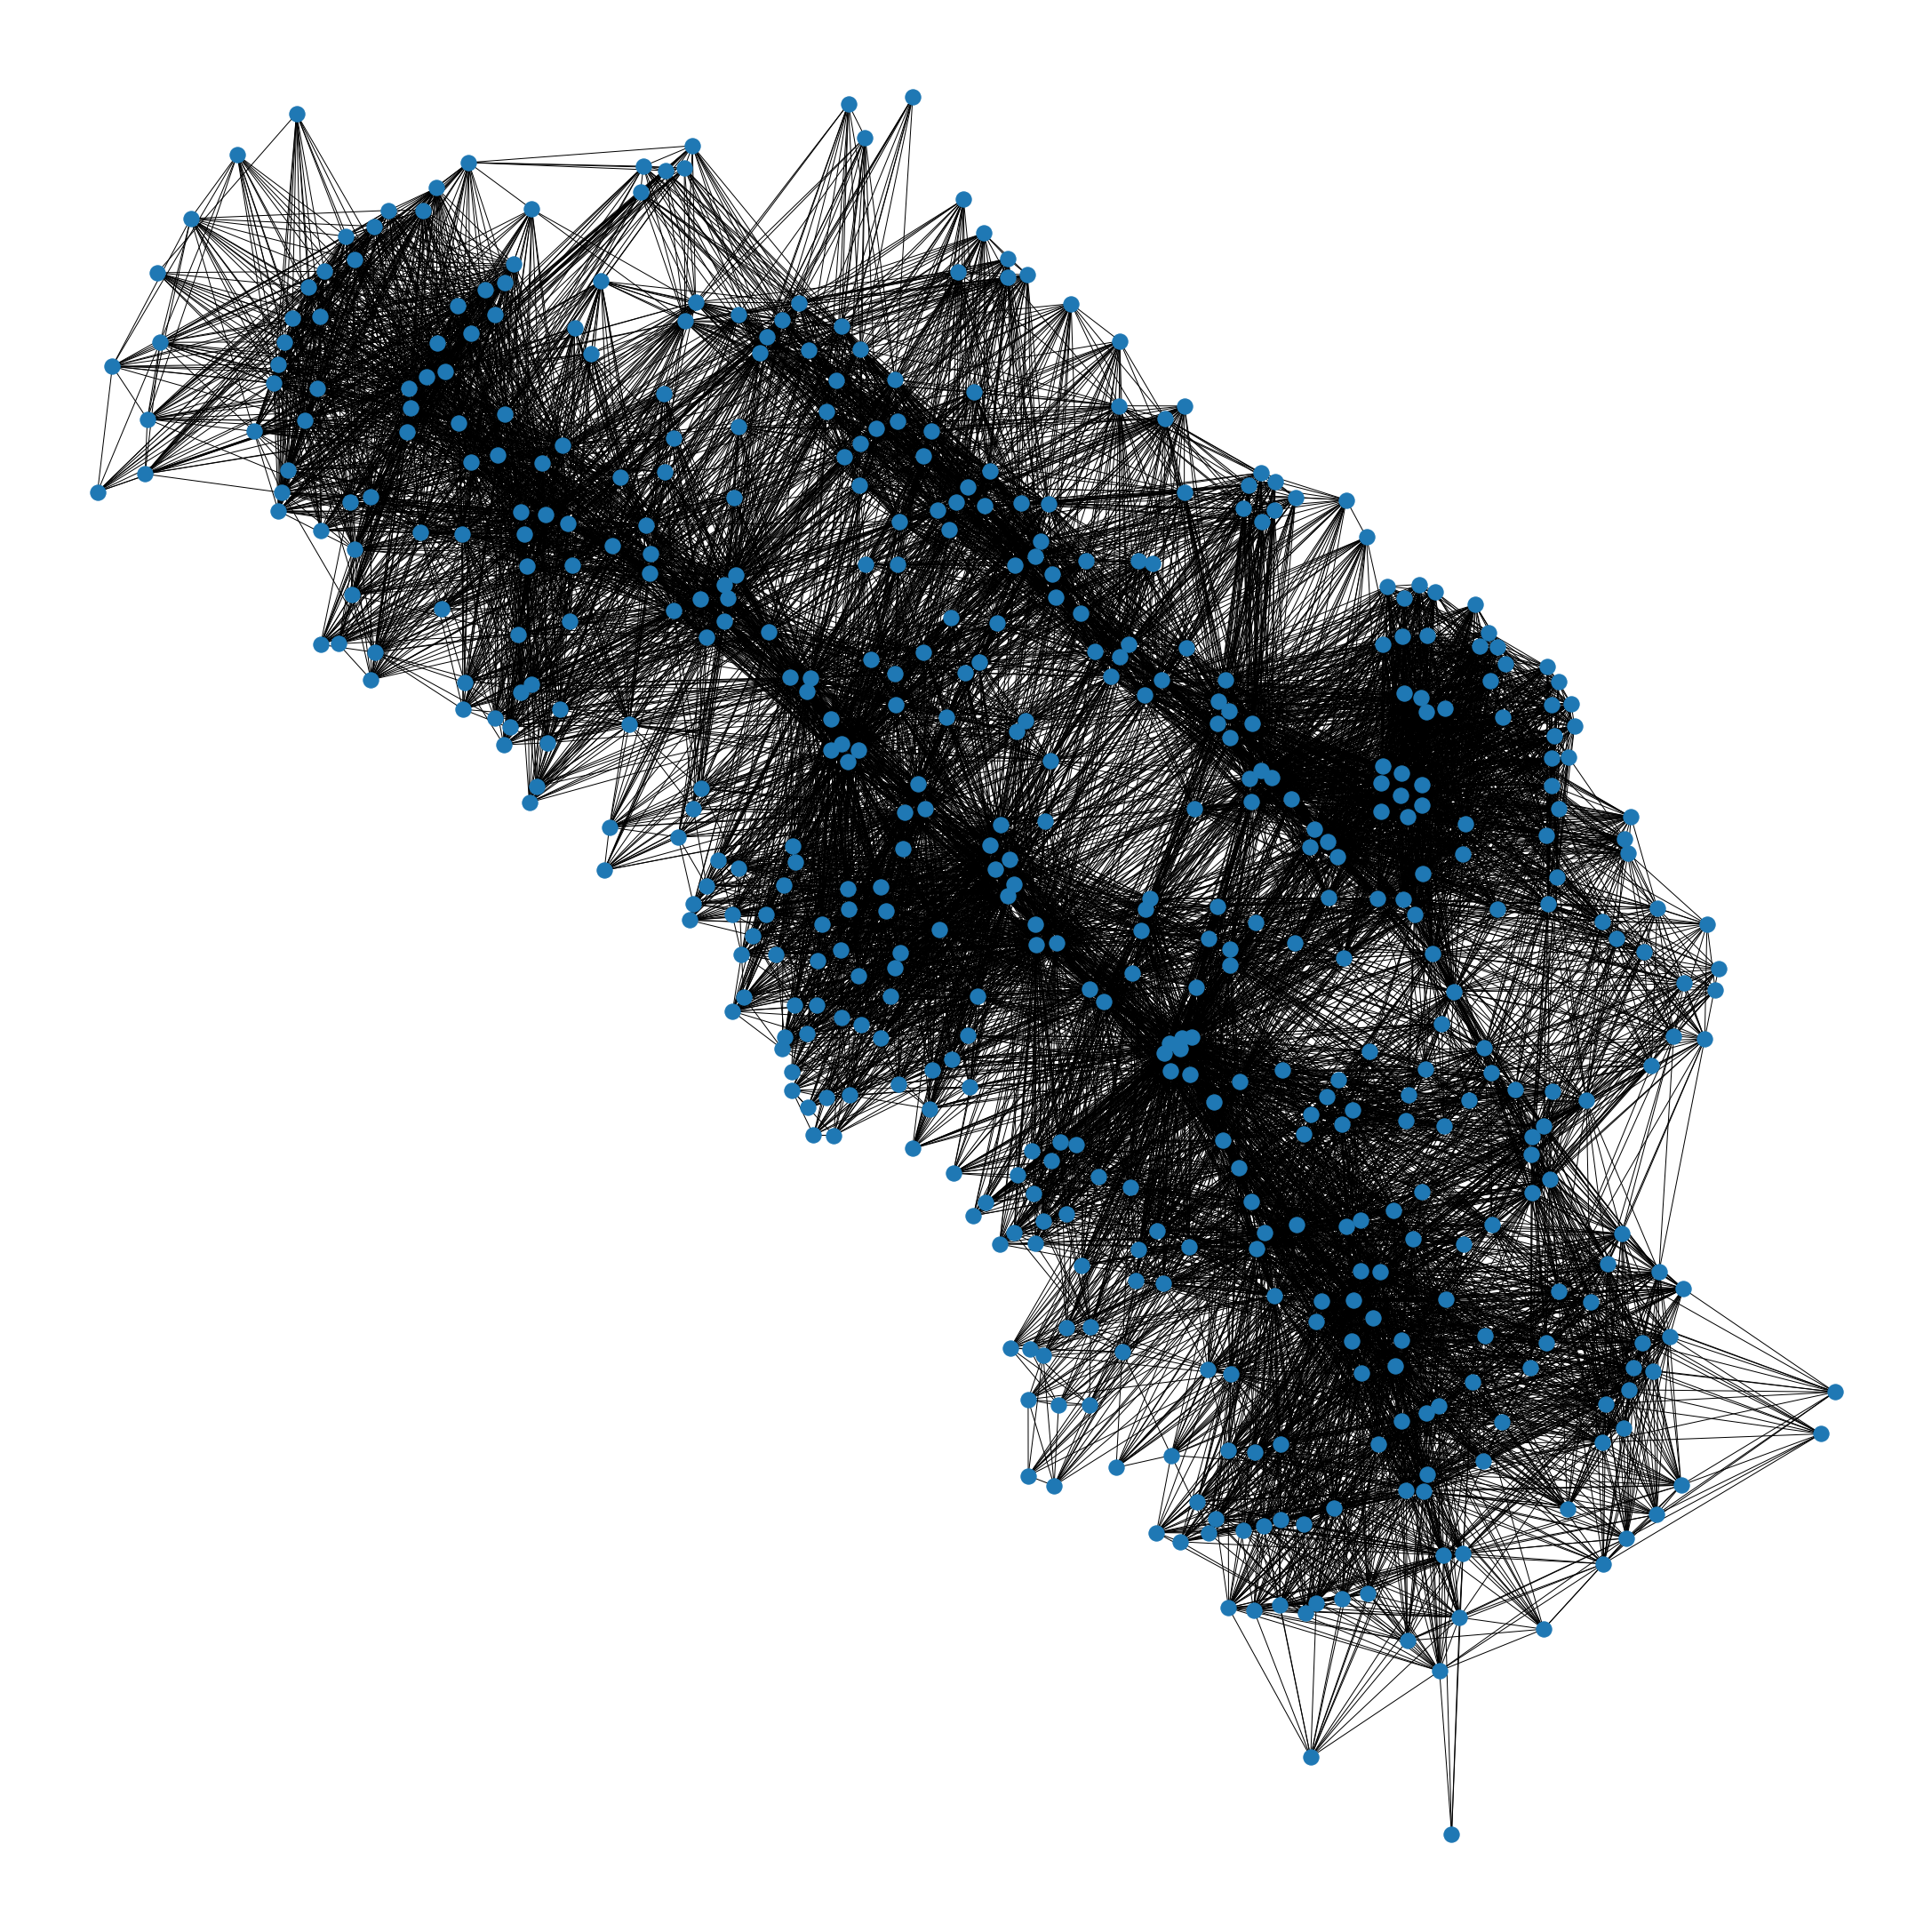

In [14]:
G = nx.Graph()
G.add_nodes_from(index.index)

for tile, row in index.iterrows():
    for overlap_tile in row['clipped_overlap']:
        G.add_edge(tile, overlap_tile)
plt.figure(figsize=(30,30))
nx.draw_kamada_kawai(G, with_labels=False)


### Function to Open Raster from ArcticDEM server, mask, and save it

See Rasterio Documentation: https://rasterio.readthedocs.io/en/latest/topics/datasets.html


**NOTE: Formats can be combined (ex. a tar.gz file from a remote server) by adding a '+' character.** 

URL Format: **'tar+' + url_to_arctic_dem + '!' + filename**


In [ ]:
def ArcticDEM_from_server(raster, overwrite=False, out_dir='../data/rasters/'):
    
    outfile = '../data/rasters/' + raster.name + '.tif'
    
    if os.path.exists(outfile) and not overwrite:
        print(raster.name, 'already exists and overwrite==False')
        return
        
    url = raster['fileurl']
    rio_url = 'tar+' + url + '!' + raster.name + '_dem.tif'  # format url for remote access
    
    print('Opening', rio_url)
    src = rio.open(rio_url)
    
    xmin, xmax = raster['minx'], raster['maxx']
    ymin, ymax = raster['miny'], raster['maxy']
        
    bbox = shapely.geometry.box(raster['minx'], raster['miny'], raster['maxx'], raster['maxy'])  # create bounding box for area of interest
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=src.crs)
    geo = [json.loads(geo.to_json())['features'][0]['geometry']]
    
    print('Masking', bbox)
    out_img, out_transform = mask(src, shapes=geo, crop=True)  # Mask the raster
    out_img = np.squeeze(out_img)

    
    out_meta = src.meta.copy()
    out_meta.update({'driver':'GTiff',
                     'height': out_img.shape[0],
                     'width': out_img.shape[1],
                     'transform': out_transform,
                     'crs': src.crs
                    })
    
    
    with rio.open(out_dir + raster.name + '.tif', 'w', **out_meta) as dst:
        dst.write(out_img, 1)
    return


### Looking at Pingo Sites

#### DEM
<img src="https://i.imgur.com/2MpRVdZ.png">

#### Slope
<img src="https://i.imgur.com/jh4U3hB.png">

#### Aspect
<img src="https://i.imgur.com/hkYr8IA.png">




#### Notes:

1. Aspect could be a useful parameter, they show interesting behavior at pingo sites.
2. Slope could be useful 

### Calculate Difference in Overlapping Rasters

Two overlapping rasters were loaded into QGIS and their difference calculated using the Raster Calculator.

Raster 1: SETSM_GE01_20120812_10504100007A7300_1050410000751500_seg1_2m_v3.0_dem.tif

Raster 2: SETSM_GE01_20120812_10504100007CE100_1050410000778700_seg1_2m_v3.0_dem.tif


We will calculate the mean difference between these.

In [15]:
with rio.open('../data/rasters/overlap_diff.tif') as src:
    data = src.read(1)
    mask_array = src.read_masks(1)
    diff = data * mask_array / 255
    print('Mean Difference:', diff.mean())
    print('Max Difference:', diff.max())
    print('Min Difference:', diff.min())

Mean Difference: -0.40636072
Max Difference: 40.741398
Min Difference: -30.982344


#### Notes: 

The average difference between these two rasters is about half a meter.

The following image shows data where the difference is greater than 10 meters.

Note the large peak differences come from bodies of water that were not properly masked in the ArcticDEM. We can create a small buffer around these as a potential fix.

<img src="https://i.imgur.com/ip2UJoD.png">

### Choose a Bounding Box, get all rasters for it

#### Find rasters which have the exact same xmin, xmax, ymin, ymax.

These should be spatially identical, allowing us to compare them temporally.

In [36]:
same_clipped_extent = index.duplicated(subset=['minx', 'miny', 'maxx', 'maxy'])
print(same_clipped_extent.value_counts())

index_str = index.astype(str)
same_geometry = index_str.duplicated(subset=['geometry'])
print(same_geometry.value_counts())

False    517
dtype: int64
False    517
dtype: int64


There are no rasters with exactly the same spatial extent, we will need to pick a small bounding box and crop accordingly.

#### Pick a random bounding box
<img src="https://i.imgur.com/g6qL4PZ.png">

In [5]:
bbox_shp = shapely.geometry.box(-2059067.721554153,659099.7355379032,-2058275.3307141757,659600.3177751342)
bbox_rio = rio.coords.BoundingBox(-2059067.721554153,659099.7355379032,-2058275.3307141757,659600.3177751342)

#### Find rasters with a bounding box that overlaps this one

We will use both shapely and rasterio bounding boxes to validate the results.

In [6]:
candidates_shp = []
candidates_rio = []
for name, row in index.iterrows():
    compare_bbox_shp = shapely.geometry.box(row['minx'], row['miny'], row['maxx'], row['maxy'])
    compare_bbox_rio = rio.coords.BoundingBox(row['minx'], row['miny'], row['maxx'], row['maxy'])
    
    # SHAPELY
    if bbox_shp.intersects(compare_bbox_shp):
        candidates_shp.append(name)
        
    # RASTERIO
    if not rio.coords.disjoint_bounds(bbox_rio, compare_bbox_rio):
        candidates_rio.append(name)

In [7]:
candidates_shp == candidates_rio

True

Both modules provided the same result, so we'll continue with the shapely results.

In [8]:
rasters = candidates_shp
len(rasters)

19

#### Download the rasters of interest

I'm making some functions to avoid repeating this later.

In [3]:
def find_overlapping_rasters(bbox):
    
    '''
    Returns a list of rasters which will potentially have data at the location of your bounding box.
    '''
    
    overlap = []

    for name, row in index.iterrows():
        
        # Construct a bounding box using the provided clip area
        compare_bbox = shapely.geometry.box(row['minx'], row['miny'], row['maxx'], row['maxy'])
        
        # If the selected bbox is **within** the raster's area
        # (you can change this to '.intersects', but that may include rasters w/ only partial coverage)
        if bbox.within(compare_bbox):
            overlap.append(name)
    return overlap

In [4]:
def mask_and_download(raster, bbox, out_dir, overwrite=False):
    
    '''
    Takes a row of the index .csv and downloads the file, masking it to your bounding box.
    '''
    
    outfile = out_dir + raster.name + '.tif'
    
    # Check if the file already exists
    if os.path.exists(outfile) and not overwrite:
        return
    
    url = raster['fileurl']
    
    # Format url for remote access
    rio_url = 'tar+' + url + '!' + raster.name + '_dem.tif'  
    
    print(raster.name)
#     print('URL:', url)
#     print()
    
    # Open the raster from the ArcticDEM Server
    src = rio.open(rio_url)
    
    # Convert bounding box to rasterio desired format
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=src.crs)
    geo = [json.loads(geo.to_json())['features'][0]['geometry']]
    
    # Mask the raster, remove singleton dimensions
    out_img, out_transform = mask(src, shapes=geo, crop=True)
    out_img = np.squeeze(out_img)
    
    # Update the metadata with the new height, width, position, projection
    out_meta = src.meta.copy()
    out_meta.update({'driver':'GTiff',
                     'height': out_img.shape[0],
                     'width': out_img.shape[1],
                     'transform': out_transform,
                     'crs': src.crs
                    })
    
    # Check if the raster contains usable data
    msk = np.ma.masked_equal(out_img, src.nodata)
    if np.all(msk.mask):  # If all of the values are True (nodata)
        print('No data in this raster')
        return
    
    # If all good, write the file
    with rio.open(outfile, 'w', **out_meta) as dst:
        dst.write(out_img, 1)
        
    print('Wrote to', outfile)

In [13]:
def earthpy_mask_and_download(raster, bbox, out_dir, overwrite=False):
    
    '''
    Takes a row of the index .csv and downloads the file, masking it to your bounding box.
    '''
    
    outfile = out_dir + raster.name + '.tif'
    
    # Check if the file already exists
    if os.path.exists(outfile) and not overwrite:
        return
    
    url = raster['fileurl']
    
    # Format url for remote access
    rio_url = 'tar+' + url + '!' + raster.name + '_dem.tif'  
    
    print(raster.name)
#     print('URL:', url)
#     print()
    
    # Open the raster from the ArcticDEM Server
    src = rio.open(rio_url)
    
    print('Done loading')
    
    # Convert bounding box to rasterio desired format
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=src.crs)
    geo = [json.loads(geo.to_json())['features'][0]['geometry']]
    
    # Mask the raster, remove singleton dimensions
    out_img, out_meta = earthpy.spatial.crop_image(src, shapes=geo)
    out_img = np.squeeze(out_img)
    print('Done masking')
    # Update the metadata with the new height, width, position, projection
    out_meta = src.meta.copy()
    out_meta.update({'driver':'GTiff',
                     'height': out_img.shape[0],
                     'width': out_img.shape[1],
                     'transform': out_meta['transform'],
                     'crs': src.crs
                    })
    
    # Check if the raster contains usable data
    msk = np.ma.masked_equal(out_img, src.nodata)
    if np.all(msk.mask):  # If all of the values are True (nodata)
        print('No data in this raster')
        return
    
    # If all good, write the file
    with rio.open(outfile, 'w', **out_meta) as dst:
        dst.write(out_img, 1)
        
    print('Wrote to', outfile)

In [ ]:
for raster in find_overlapping_rasters(bbox_shp):
    mask_and_download(index.loc[raster], bbox_shp, overwrite=False)

### bbox1 Results

Only 4 out of 19 rasters were valid, they are displayed in the GIF below.

1. SETSM_W1W1_20090311_102001000620D300_1020010007A8BA00_seg2_2m_v3.0
2. SETSM_WV01_20120713_102001001BE7BD00_102001001C20A300_seg1_2m_v3.0
3. SETSM_WV02_20150523_1030010044050B00_10300100423D6200_seg1_2m_v3.0
4. SETSM_WV03_20160623_104001001D0DBC00_104001001E2DE800_seg1_2m_v3.0


![SegmentLocal](https://i.imgur.com/yjV4mNk.gif "segment")


### bbox2

In [11]:
bbox_shp = shapely.geometry.box(-2050855.1721045878,654482.1186140846,-2049549.3366074134,655322.7937930436)

In [92]:
def worker(name):    
    data = index.loc[name]
    mask_and_download(data, bbox_shp, '../data/overlapping_rasters/bbox3/', overwrite=False)

In [ ]:
pool = Pool()
pool.map(worker, find_overlapping_rasters(bbox_shp))

#### Results of bbox2

Only 4 rasters were valid again. They are the same ones as bbox1

1. SETSM_W1W1_20090311_102001000620D300_1020010007A8BA00_seg2_2m_v3.0.tif
2. SETSM_WV01_20120713_102001001BE7BD00_102001001C20A300_seg1_2m_v3.0.tif
3. SETSM_WV02_20150523_1030010044050B00_10300100423D6200_seg1_2m_v3.0.tif
4. SETSM_WV03_20160623_104001001D0DBC00_104001001E2DE800_seg1_2m_v3.0.tif


#### Comparison of bbox1 and bbox2

bbox1 is in upper left, bbox2 lower right

The close proximity is probably the reason they are covered by the same rasters.

<img src="https://i.imgur.com/prlgycj.png">

### bbox3 

In [7]:
bbox3=shapely.geometry.box(-2108480.7936384403,697556.1588105172,-2104585.5964178317,700016.8971744349)

In [31]:
files = find_overlapping_rasters(bbox3)
len(files)

29

In [ ]:
pool = Pool()
pool.map(worker, files)

Opening SETSM_WV01_20131014_102001002596D400_102001002722E700_seg3_2m_v3.0
Opening SETSM_WV01_20131026_1020010026BFD500_1020010026203A00_seg1_2m_v3.0
URL: http://data.pgc.umn.edu/elev/dem/setsm/ArcticDEM/geocell/v3.0/2m/n69w154/SETSM_WV01_20131026_1020010026BFD500_1020010026203A00_seg1_2m_v3.0.tar.gz
Opening SETSM_WV01_20130411_10200100203AB200_102001001F39B600_seg1_2m_v3.0
Opening SETSM_W2W2_20140315_103001002F585A00_103001002FC05300_seg1_2m_v3.0
Opening SETSM_W1W2_20130510_1020010023A8F000_1030010022936800_seg2_2m_v3.0
Opening SETSM_WV02_20160622_10300100595FFD00_1030010058C40100_seg1_2m_v3.0
URL: http://data.pgc.umn.edu/elev/dem/setsm/ArcticDEM/geocell/v3.0/2m/n69w154/SETSM_WV01_20131014_102001002596D400_102001002722E700_seg3_2m_v3.0.tar.gz
Opening SETSM_W2W2_20140315_103001002D569100_103001002E663D00_seg1_2m_v3.0
URL: http://data.pgc.umn.edu/elev/dem/setsm/ArcticDEM/geocell/v3.0/2m/n69w154/SETSM_W2W2_20140315_103001002F585A00_103001002FC05300_seg1_2m_v3.0.tar.gz
Opening SETSM_WV02_

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-35-50170eb13fd4>", line 2, in <module>
    pool.map(worker3, files)
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 288, in map
    return self._map_async(func, iterable, mapstar, chunksize).get()
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 664, in get
    self.wait(timeout)
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 661, in wait
    self._event.wait(timeout)
  File "/opt/conda/lib/python3.6/threading.py", line 551, in wait
    signaled = self._cond.wait(timeout)
  File "/opt/conda/lib/python3.6/threading.py", line 295, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/I


KeyboardInterrupt



Opening SETSM_WV02_20150513_10300100421EA800_103001004156E900_seg1_2m_v3.0
URL: http://data.pgc.umn.edu/elev/dem/setsm/ArcticDEM/geocell/v3.0/2m/n69w153/SETSM_WV02_20150513_10300100421EA800_103001004156E900_seg1_2m_v3.0.tar.gz



Process ForkPoolWorker-40:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-33-da27e2694424>", line 3, in worker3
    mask_and_download(data, bbox3, '../data/overlapping_rasters/bbox3/', overwrite=False)
  File "<ipython-input-27-4421bbaf20fc>", line 20, in mask_and_download
    src = rio.open(rio_url)
  File "/home/jovyan/.local/lib/python3.6/site-packages/rasterio/env.py", line 445, in wrapper
    return f(*args, **kwds)
  File "/home/jovyan/.local/lib/python3.6/site-packages/rasterio/__init__.py", line 219, in open
    s = Dataset

KeyboardInterrupt: 

Exception ignored in: 'rasterio._env.log_error'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/logging/__init__.py", line 1838, in getLogger
    def getLogger(name=None):
KeyboardInterrupt
Process ForkPoolWorker-37:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-33-da27e2694424>", line 3, in worker3
    mask_and_download(data, bbox3, '../data/overlapping_rasters/bbox3/', overwrite=False)
  File "<ipython-input-27-4421bbaf20fc>", line 20, in mask_and_download
    src = rio.open(rio_url)
  File "/home/jovyan/.loc

All values are nodatavals


Process ForkPoolWorker-39:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt


In [11]:
len(glob.glob('../data/overlapping_rasters/bbox3/*.tif'))

14

Of the 29 potential rasters, only 14 had some coverage. Even out of these 14, some of them only cover one corner of the bounding box, with the rest of the bounding box as no data.

https://imgur.com/a/HqAT3zX: White means data, black means no data

Do we discard those that don't provide edge to edge coverage of the bounding box? Do we include them in the average?

## Creating a grid of the study area

In [12]:
xmin, ymin, xmax, ymax = index['minx'].min(), index['miny'].min(), index['maxx'].max(), index['maxy'].max()

In [19]:
bbox = shapely.geometry.box(xmin, ymin, xmax, ymax)

In [26]:
with open('../data/study_area.csv', 'w') as file:
    file.write('wkt;\n')
    file.write(str(bbox))

We have created a 1km square grid based on the extent of the area of study (defined above). We then filtered for only grids containing pingo features. Now, we will iterate through the grids and find / download all of the rasters for each.

#### Function to get overlapping rasters for each grid

In [75]:
def rasters_of_grids(path_to_grid_shp, overwrite=False):
    # Read grid shapefile, general formatting
    features = gpd.read_file(path_to_grid_shp)
    features = features.set_index('id', drop=True)
    features.index = features.index.astype(int)
    
    # Convert edges to bounding boxes
    features['geometry'] = features.apply(lambda x: shapely.geometry.box(x['left'], x['bottom'], x['right'], x['top']), axis='columns')
    
    # Generate a list of intersecting rasters
    features['rasters'] = features['geometry'].apply(find_overlapping_rasters)
    features['num_rasters'] = features['rasters'].apply(lambda x: len(x))
    
    features.to_pickle('../data/grid_data.pkl')
    
rasters_of_grids('../data/grid_shapefile/1km_filtered/filtered.gpkg')

In [7]:
features = pd.read_pickle('../data/grid_data.pkl')
features

left           top         right        bottom  \
id                                                              
222   -2.138483e+06  624945.32479 -2.137483e+06  623945.32479   
742   -2.136483e+06  622945.32479 -2.135483e+06  621945.32479   
1000  -2.135483e+06  623945.32479 -2.134483e+06  622945.32479   
1750  -2.132483e+06  650945.32479 -2.131483e+06  649945.32479   
1777  -2.132483e+06  623945.32479 -2.131483e+06  622945.32479   
...             ...           ...           ...           ...   
42524 -1.974483e+06  798945.32479 -1.973483e+06  797945.32479   
42782 -1.973483e+06  799945.32479 -1.972483e+06  798945.32479   
42783 -1.973483e+06  798945.32479 -1.972483e+06  797945.32479   
43033 -1.972483e+06  807945.32479 -1.971483e+06  806945.32479   
43553 -1.970483e+06  805945.32479 -1.969483e+06  804945.32479   

                                                geometry  \
id                                                         
222    POLYGON ((-2137483.335 623945.325, -2137483.33...   
742    POLYGON ((-2135483.335 621945.325, -2135483.33...   
1000   POLYGON ((-2134483.335 622945.325, -2134483.33...   
1750   POLYGON ((-2131483.335 649945.325, -2131483.33...   
1777   POLYGON ((-2131483.335 622945.325, -2131483.33...   
...                                                  ...   
42524  POLYGON ((-1973483.335 797945.325, -1973483.33...   
42782  POLYGON ((-1972483.335 798945.325, -1972483.33...   
42783  POLYGON ((-1972483.335 797945.325, -1972483.33...   
43033  POLYGON ((-1971483.335 806945.325, -1971483.33...   
43553  POLYGON ((-1969483.335 804945.325, -1969483.33...   

                                                 rasters  num_rasters  
id                                                                     
222    [SETSM_WV01_20140411_102001002B1BF000_10200100...           13  
742    [SETSM_WV01_20140411_102001002B1BF000_10200100...           13  
1000   [SETSM_WV01_20140411_102001002B1BF000_10200100...           13  
1750   [SETSM_WV01_20150412_102001003C896700_10200100...           13  
1777   [SETSM_WV01_20140411_102001002B1BF000_10200100...           13  
...                                                  ...          ...  
42524  [SETSM_WV01_20150314_102001003ADB2E00_10200100...           20  
42782  [SETSM_WV01_20150314_102001003ADB2E00_10200100...           20  
42783  [SETSM_WV01_20150314_102001003ADB2E00_10200100...           20  
43033  [SETSM_WV01_20150314_102001003ADB2E00_10200100...           28  
43553                                                 []            0  

[1263 rows x 7 columns]

#### Function to mask and download all rasters

In [109]:
def extract_all_rasters(grid):
    out_dir = '../data/rasters/grid_rasters/' + str(grid.name) + '/'
    
    if not os.path.exists(out_dir):
        print('Making', out_dir)
        os.makedirs(out_dir)
        
    pool = Pool()
    pool.map(partial(worker, bbox=grid['geometry'], out_dir=out_dir), grid['rasters'])
    
def worker(raster, bbox, out_dir, overwrite=False):
    raster = index.loc[raster]
    
    if os.path.exists(out_dir + raster.name + '_dem.tif') and not overwrite:
        return
    mask_and_download(raster, bbox, out_dir, overwrite)

### Timeseries of the Grid

We will write a function to create a timeseries of the input grid using its downloaded rasters.

In [232]:
def grid_raster_data(grid):
    '''
    returns a DataFrame for the input grid containing data about its rasters
    '''
    
    # Load all valid rasters to a DataFrame
    files = pd.DataFrame(glob.glob('../data/rasters/grid_rasters/' + str(grid.name) + '/*v3.0.tif'), columns=['name'])
    
    # Convert name to aquisition date
    files['date'] = files['name'].apply(lambda x: datetime.datetime.strptime(x[x.rfind('/')+1:x.rfind('.')].split('_')[2], '%Y%m%d'))

    # Sort by date
    files.sort_values(by='date', inplace=True)
    files.reset_index(drop=True, inplace=True)
    
    files = files.apply(raster_stats, axis='columns')
    return files
        
def raster_stats(raster):
    '''
    input: raster

    Returns mean DEM value (after applying the mask) and nodata percentage
    '''
    with rio.open(raster['name']) as src:
        data = src.read(1)  # open data
        msk = src.read_masks(1)  # open mask
        data = data * msk / 255  # mask the data
        
        unique, counts = np.unique(msk, return_counts=True)
        raster['mean'] = data.mean()
        raster['nodata_pct'] = counts[0] / (counts[0] + counts[1]) * 100
        return raster
#         return data.mean(), counts[0] / (counts[0] + counts[1]) * 100

def generate_plot(grid, labels=False, out_dir=None, **kwargs):
    '''
    Takes grid and creates a timeseries plot of it
    '''
    
    data = grid_raster_data(grid)
    fig, ax = plt.subplots(1,1, figsize=(12,8))
    ax.plot(data['date'], data['mean'], **kwargs)
    ax.set_title('Grid ' + str(grid.name))
    ax.set_ylabel('Elevation in Meters')
    ax.set_xlabel('Time')
    
    if labels:
        for index, point in data.iterrows():
            ax.annotate(round(point['nodata_pct'], 4), (point['date'], point['mean']))
    if out_dir:
        plt.savefig(out_dir, dpi=900)
    plt.show()

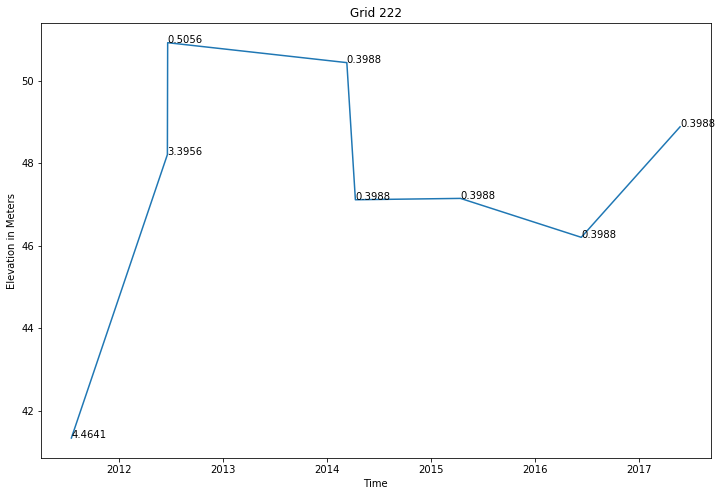

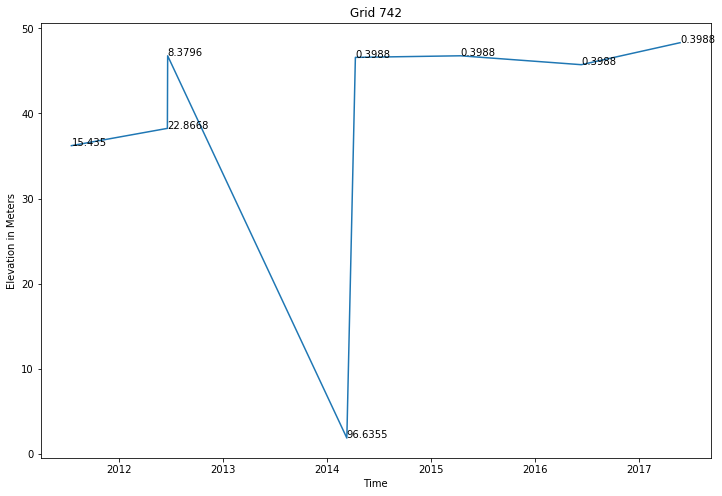

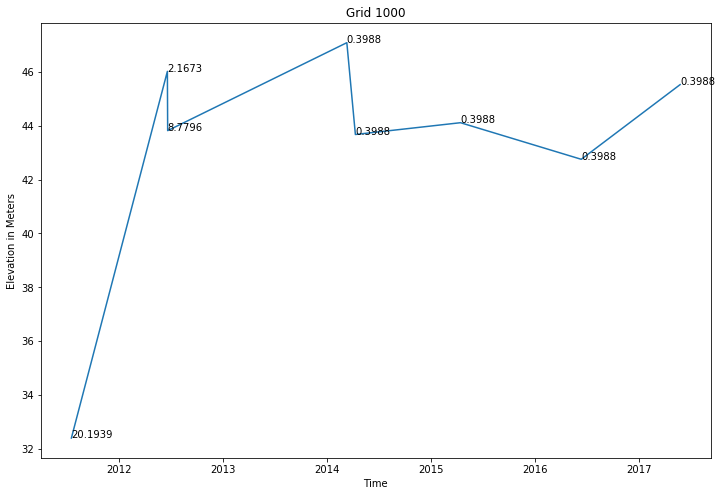

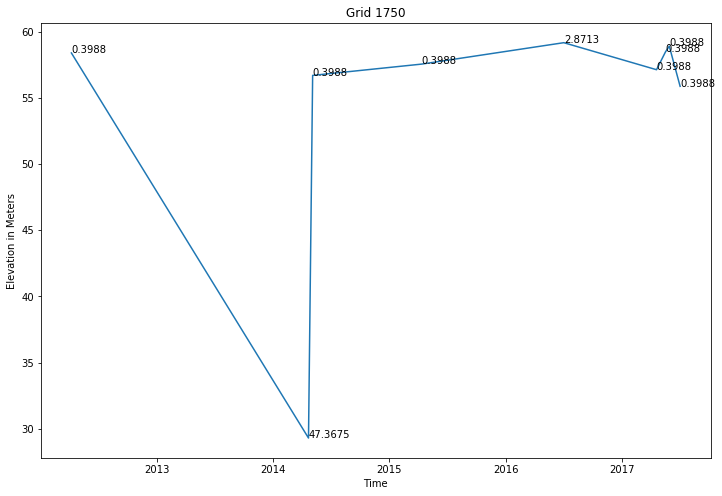

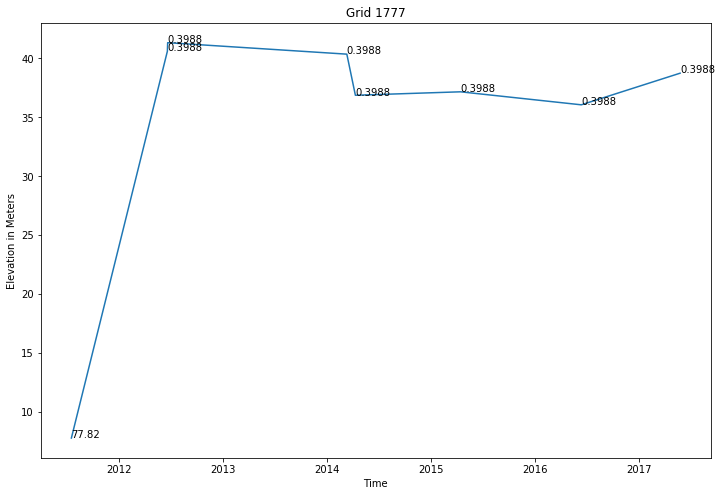

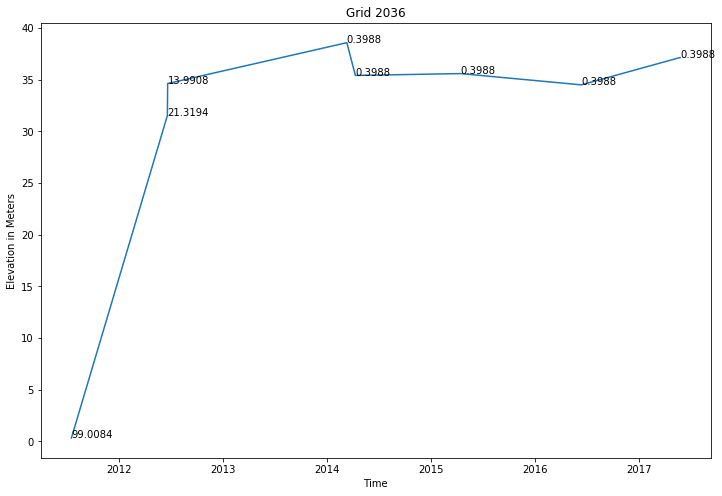

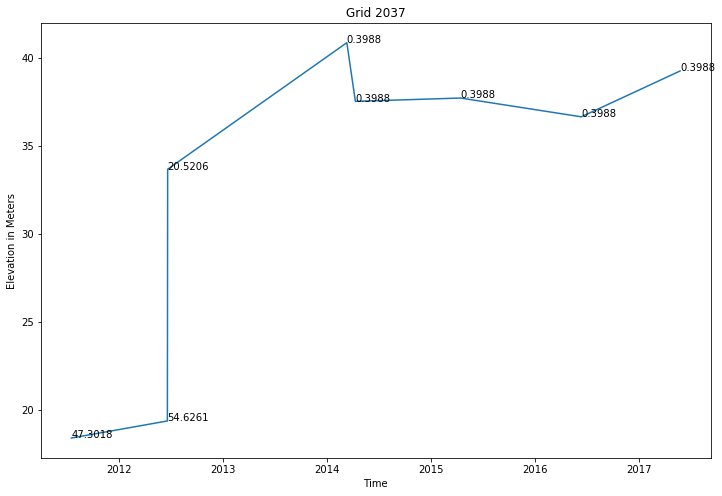

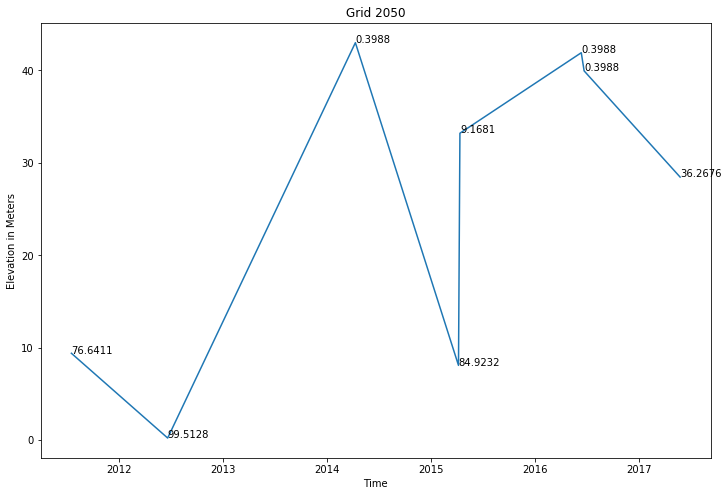

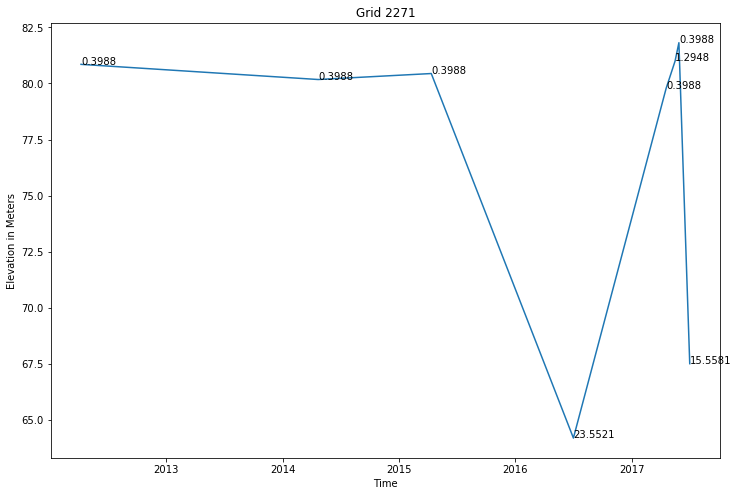

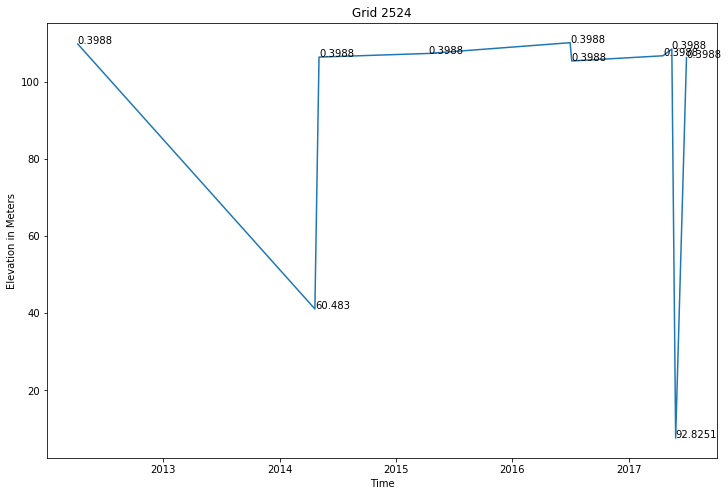

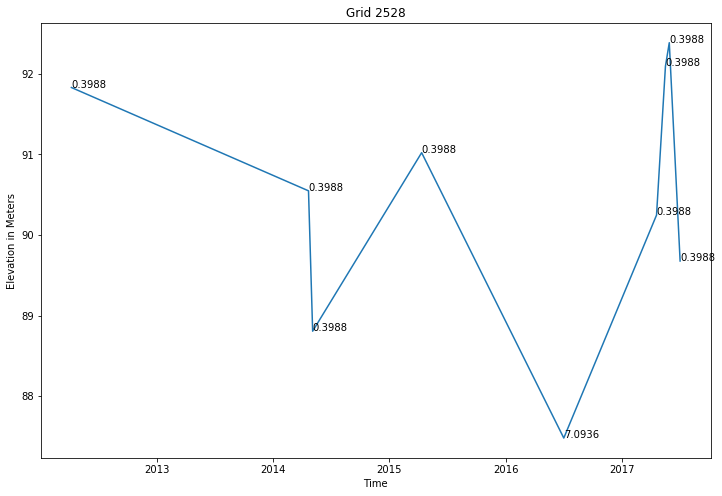

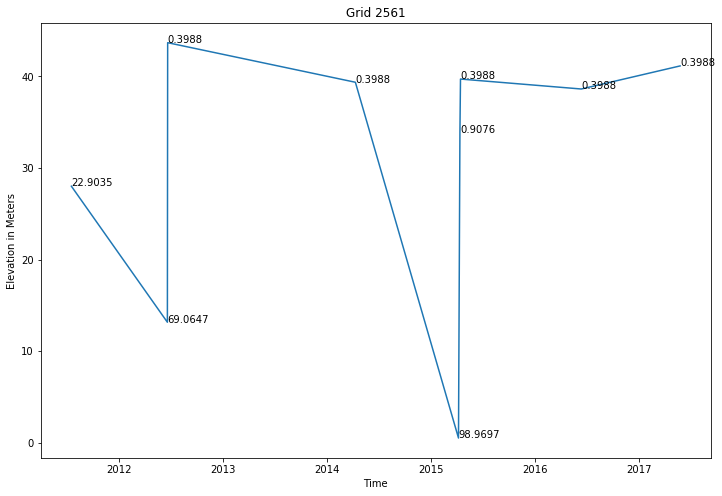

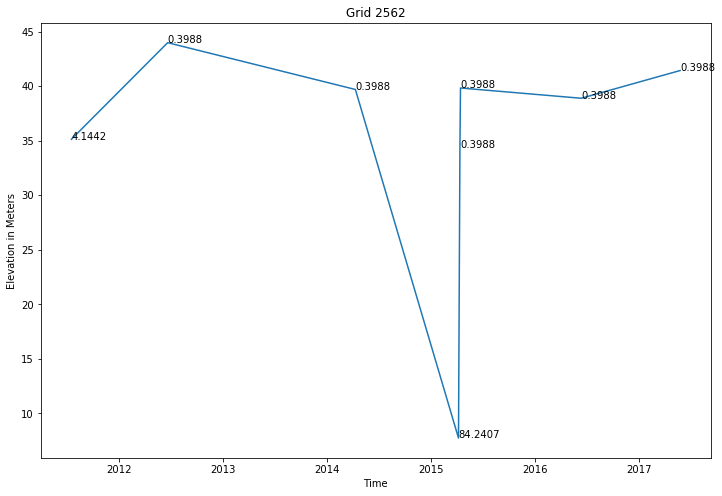

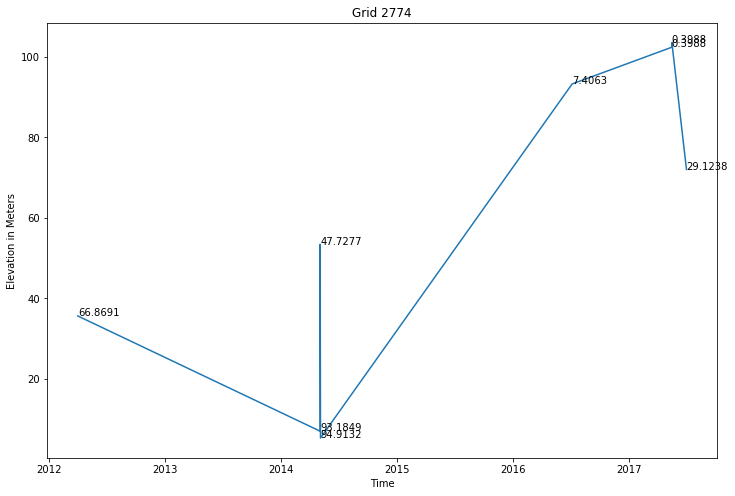

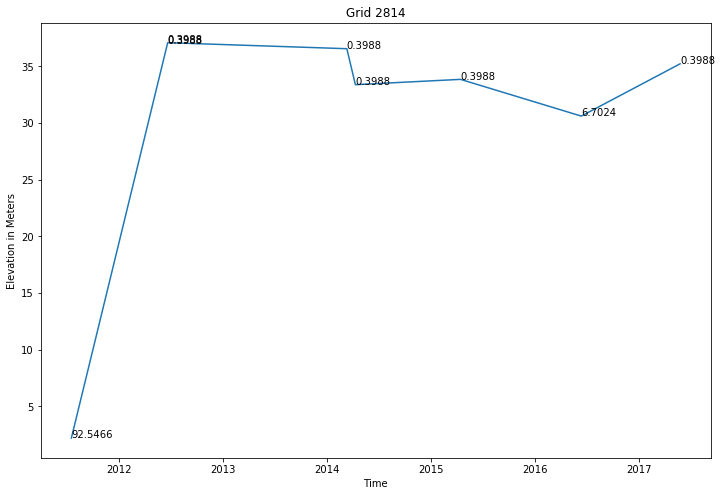

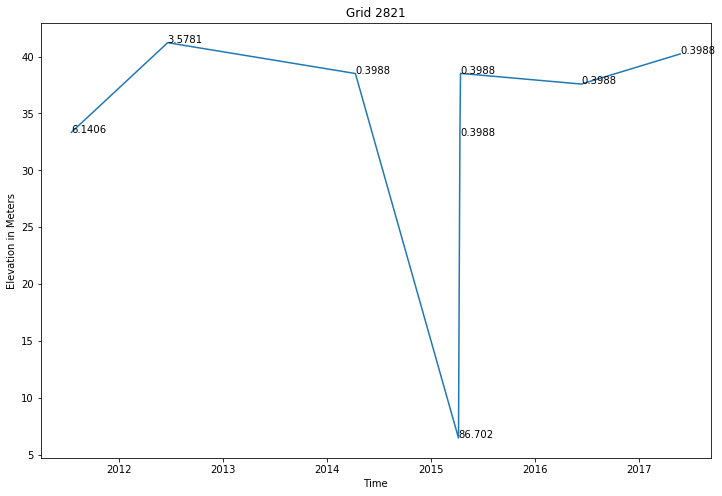

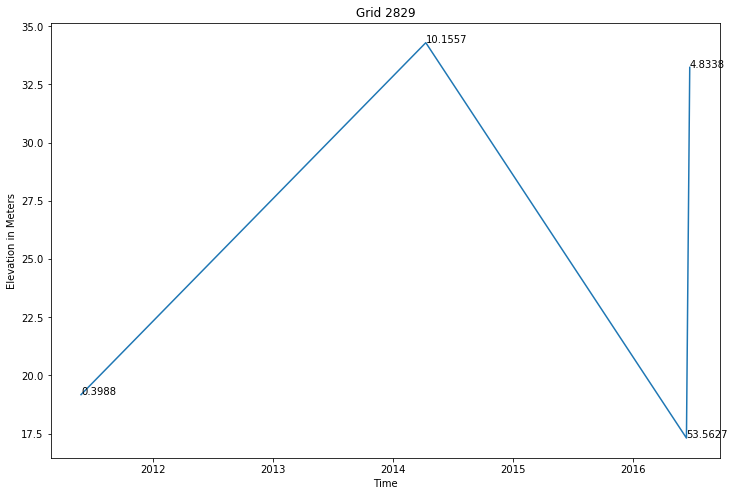

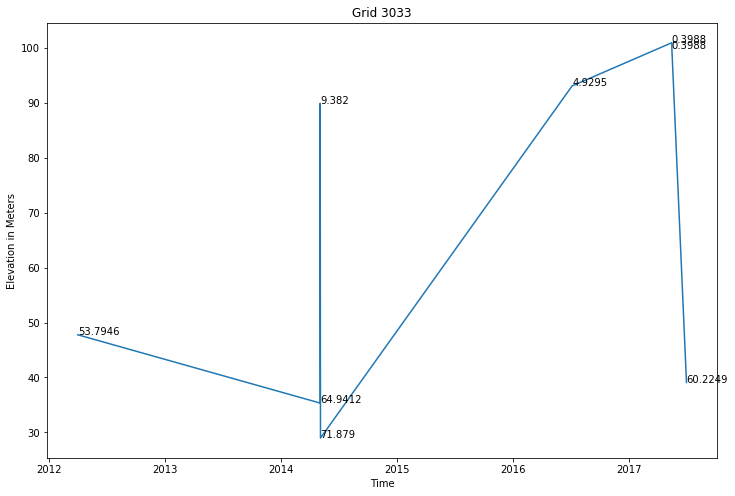

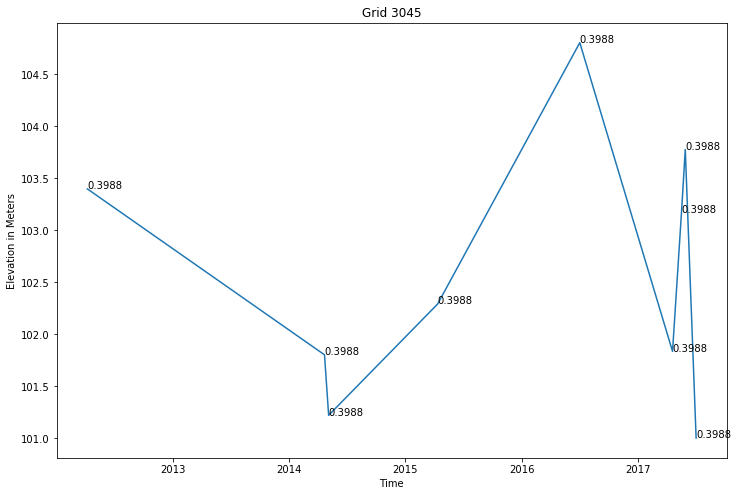

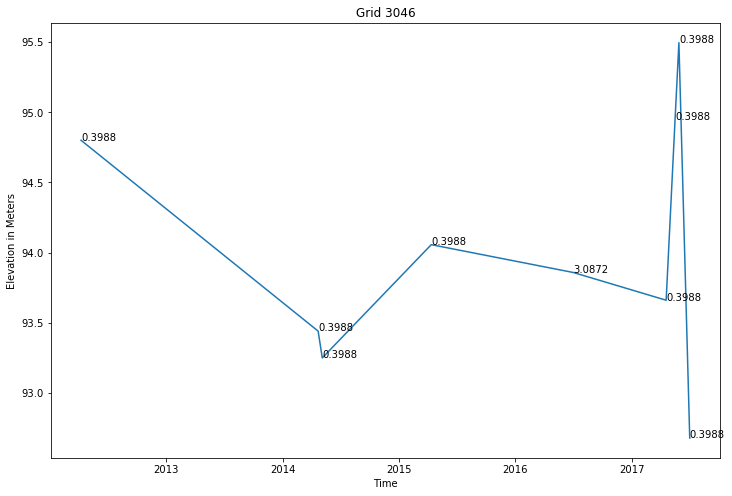

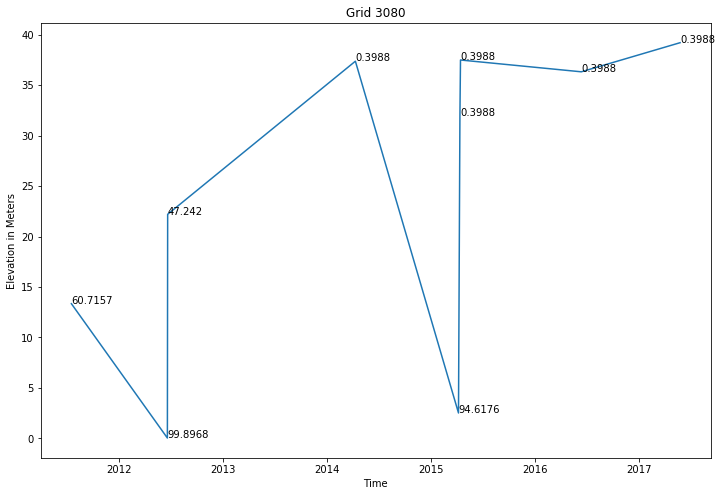

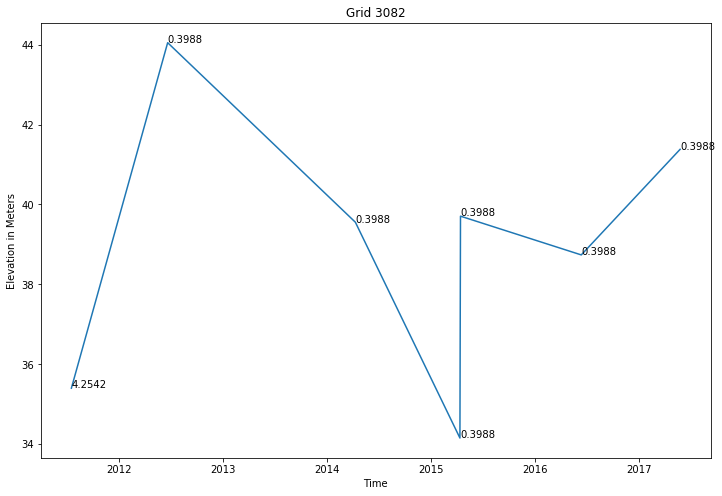

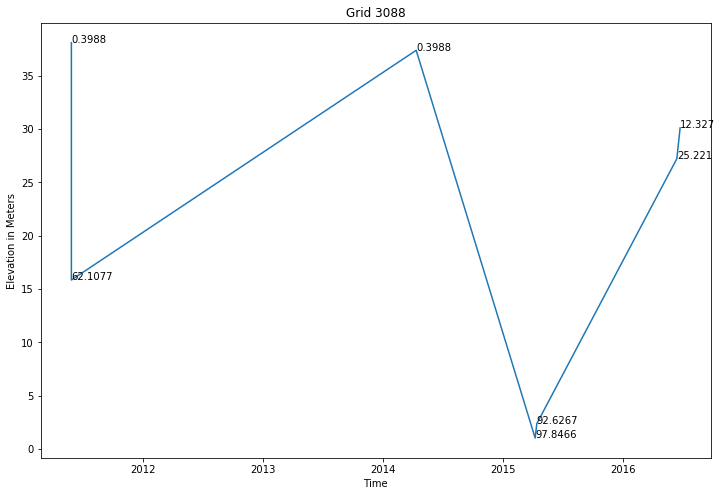

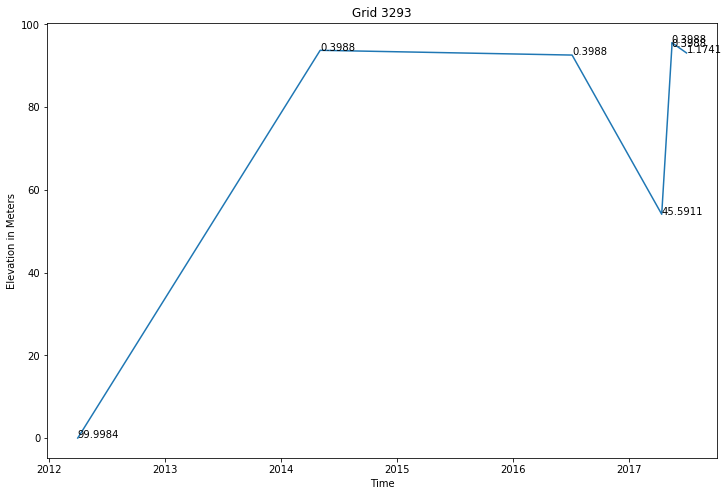

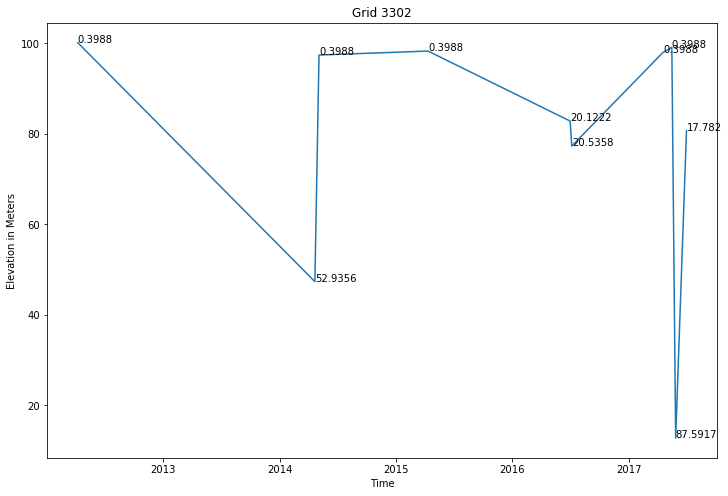

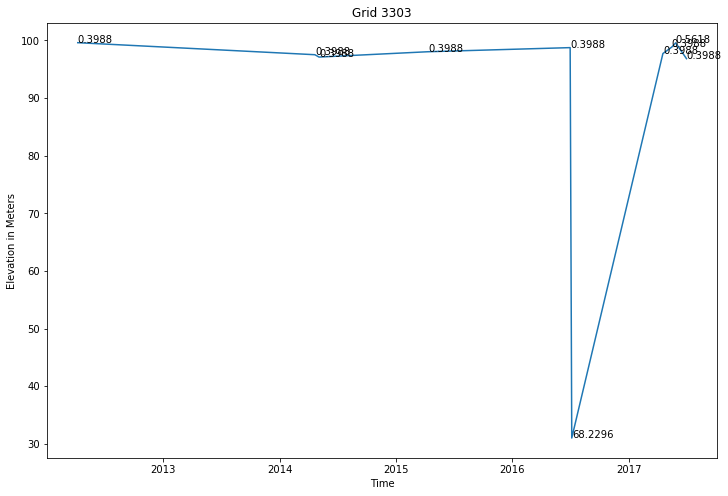

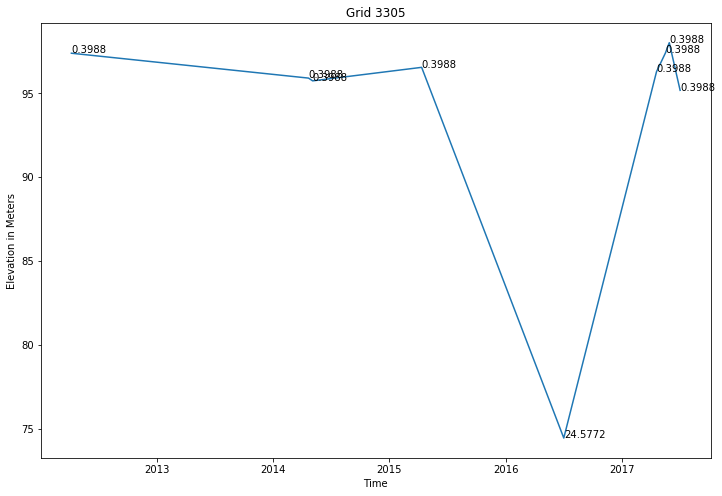

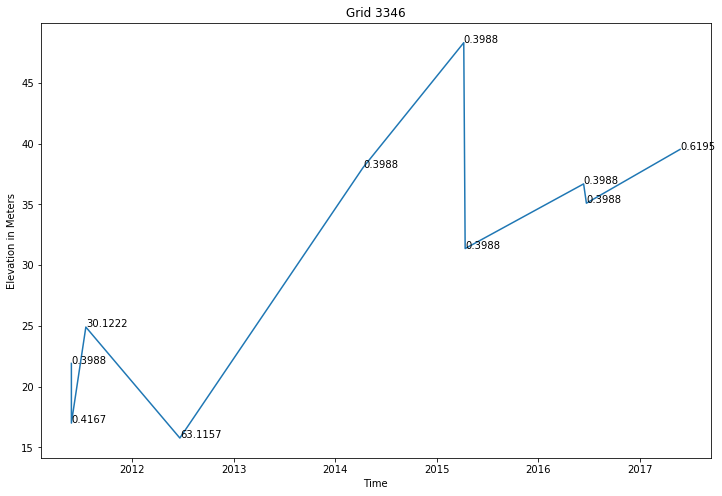

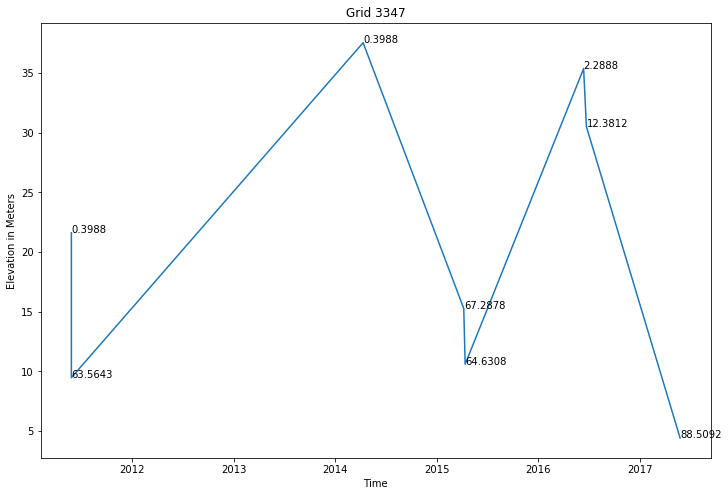

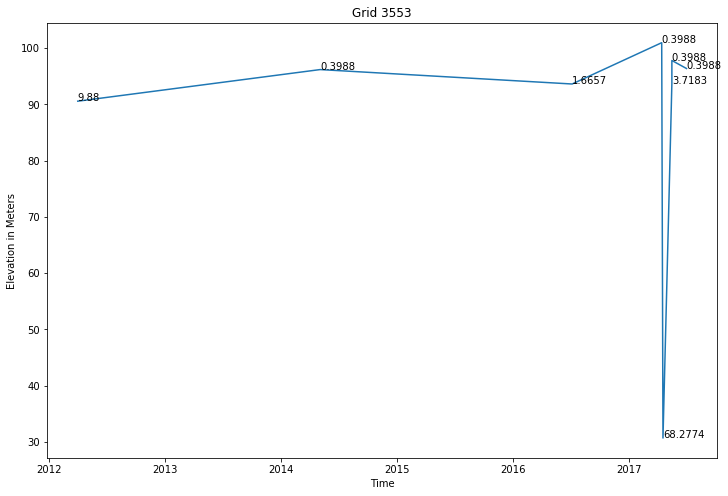

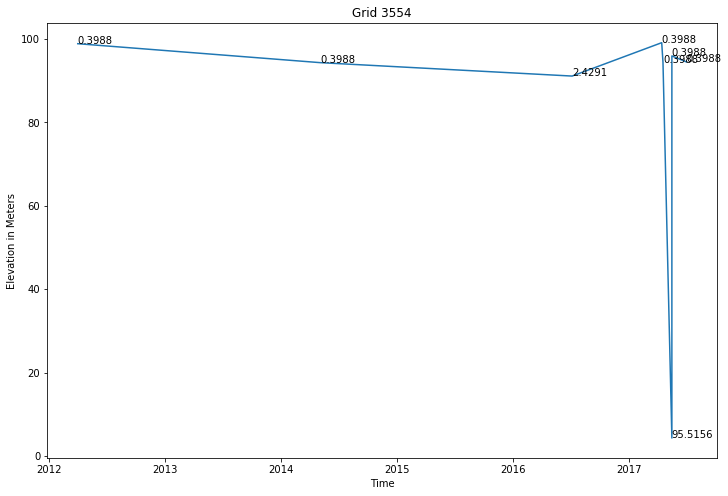

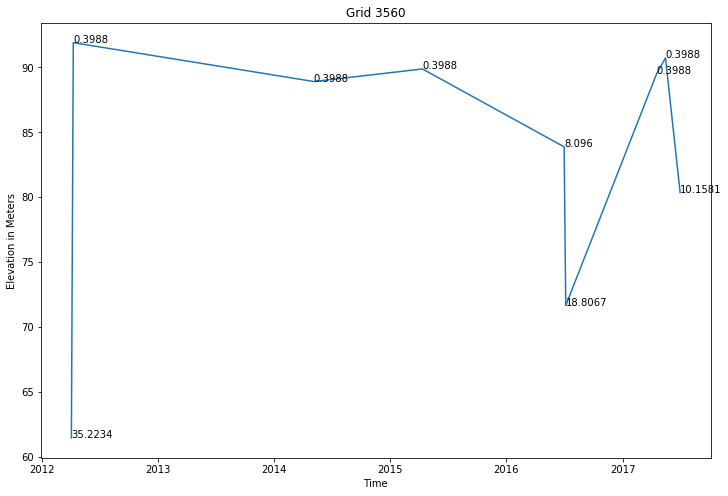

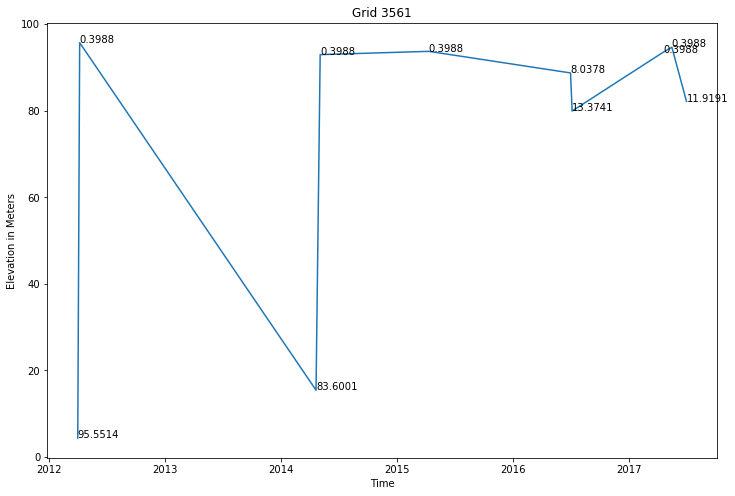

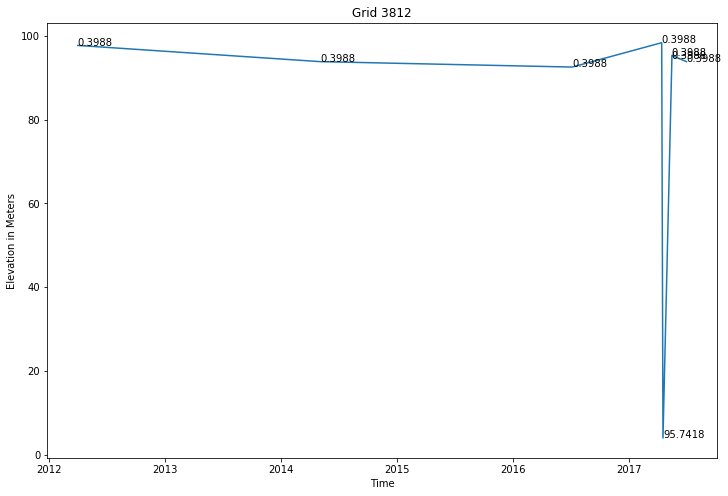

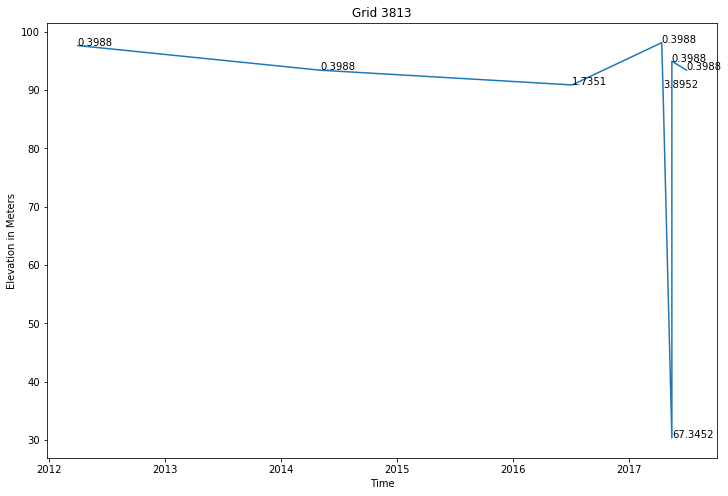

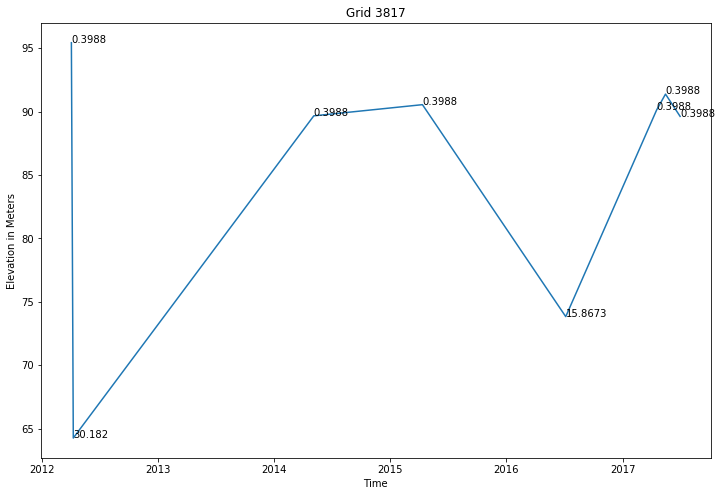

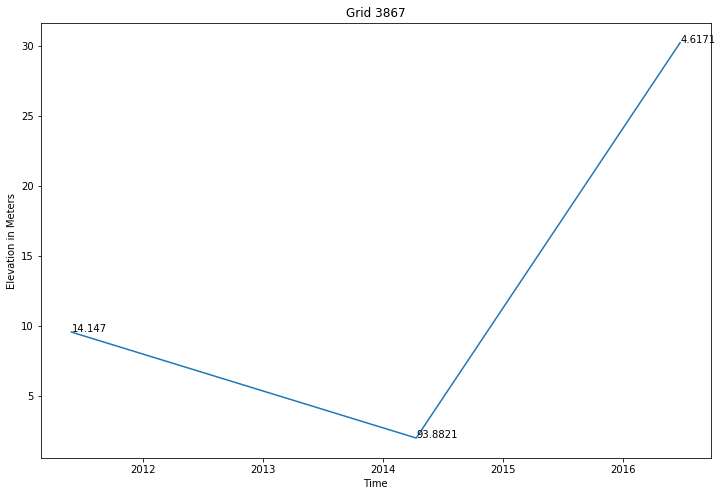

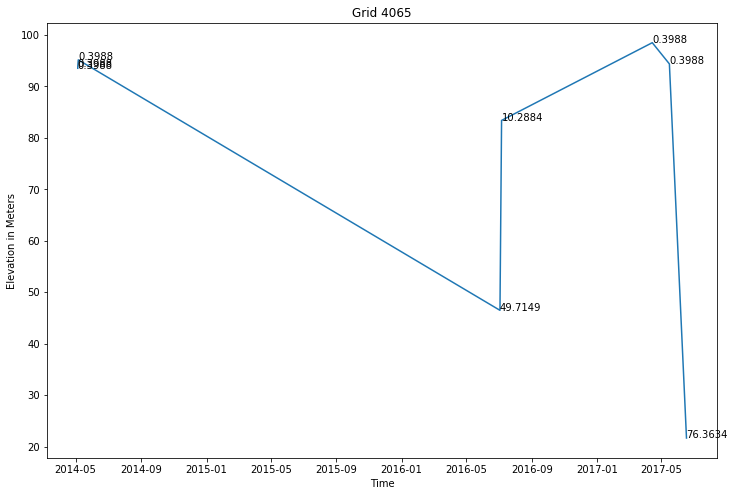

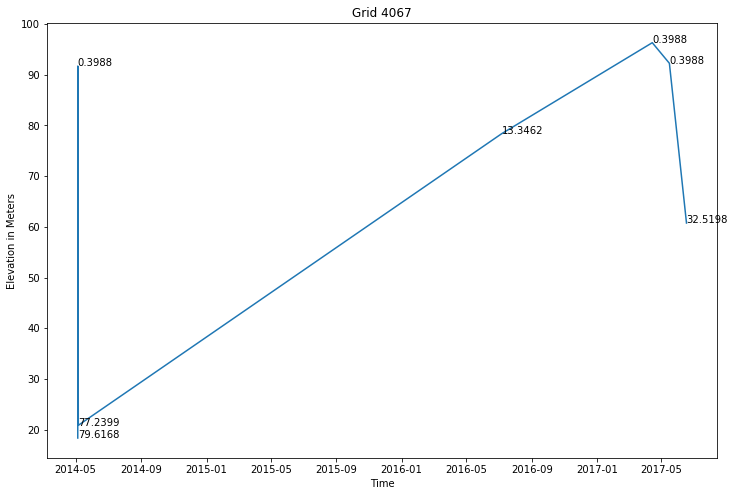

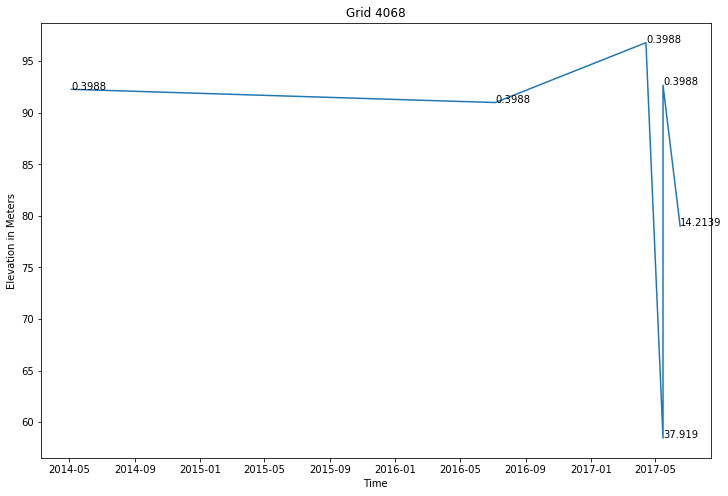

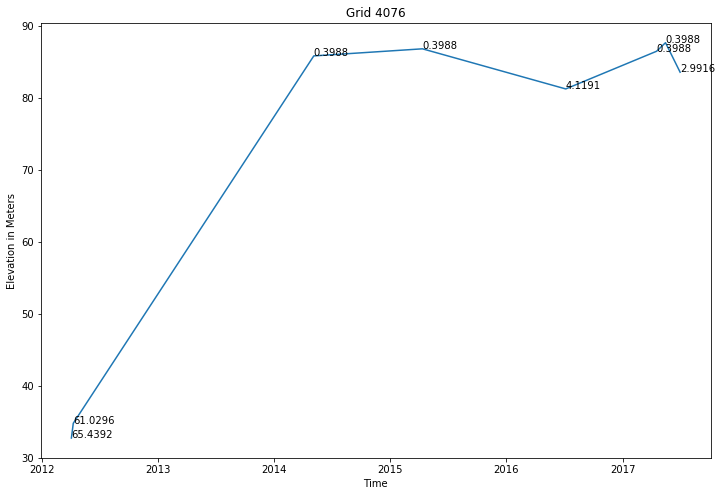

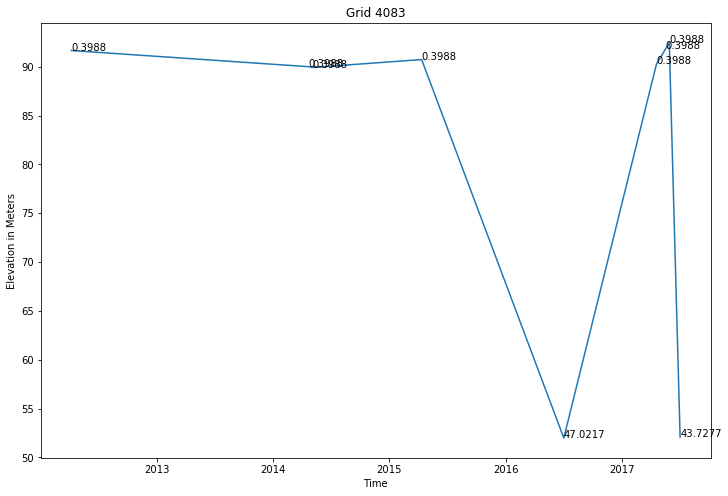

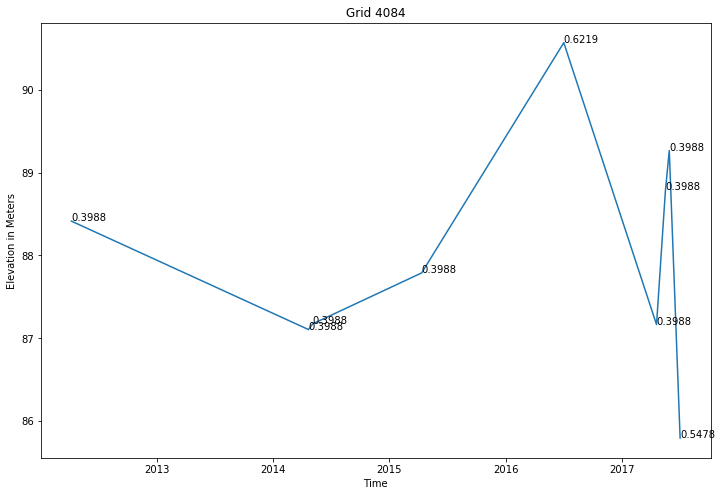

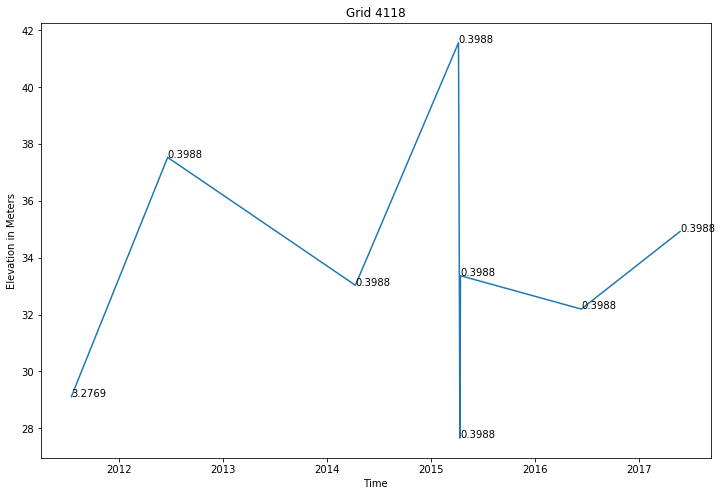

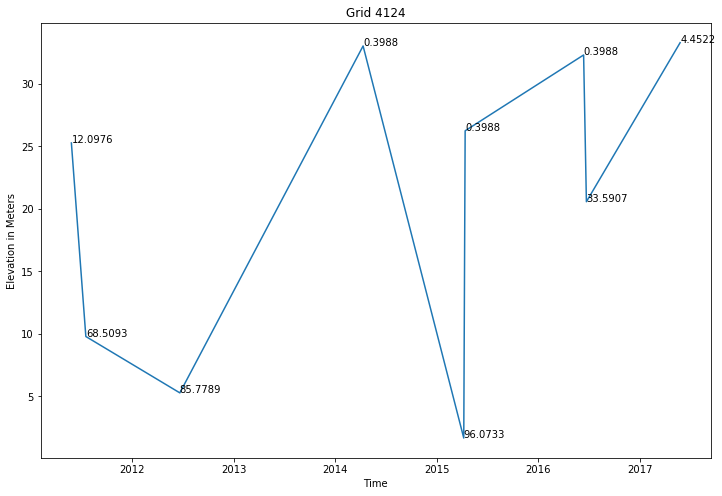

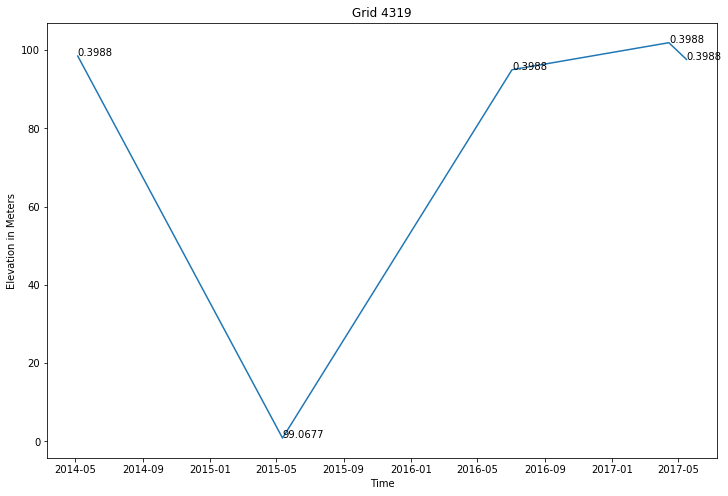

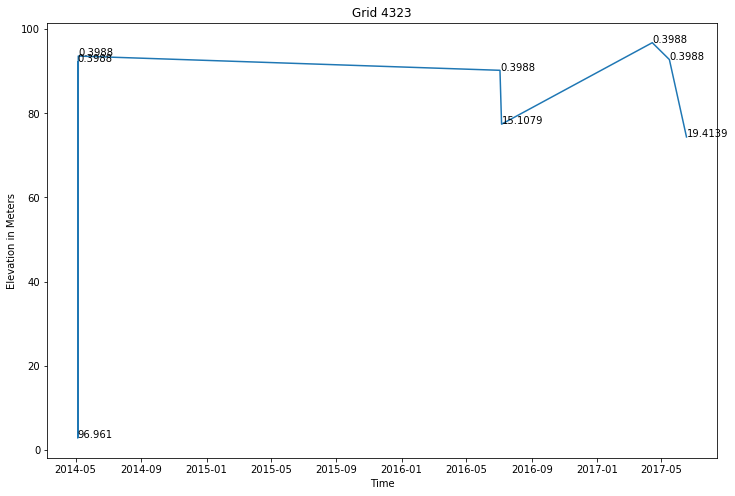

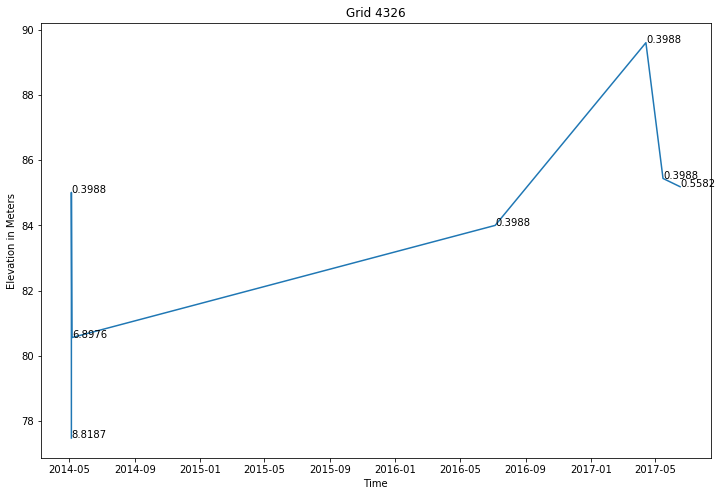

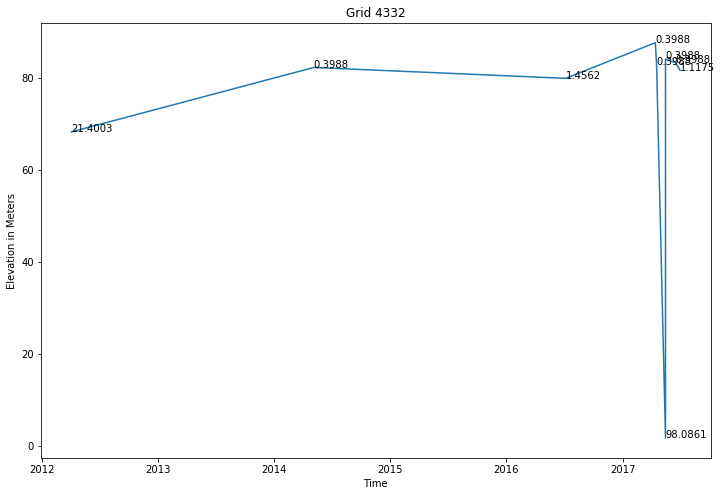

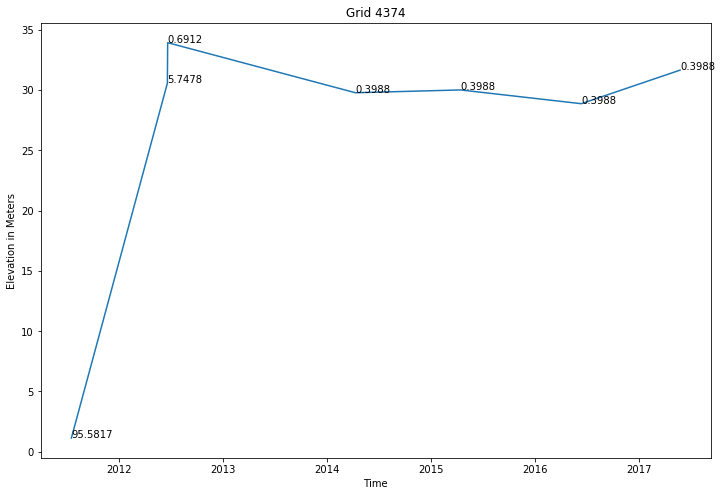

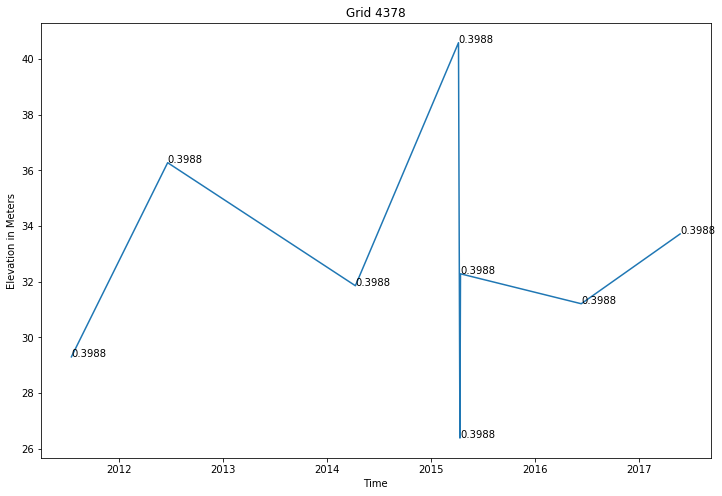

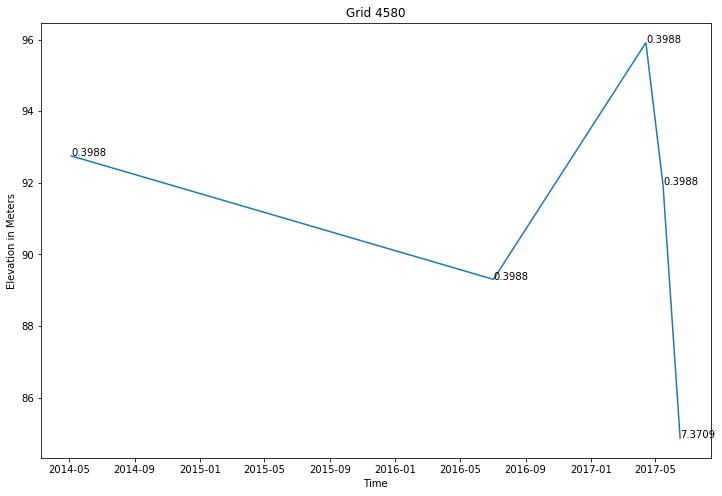

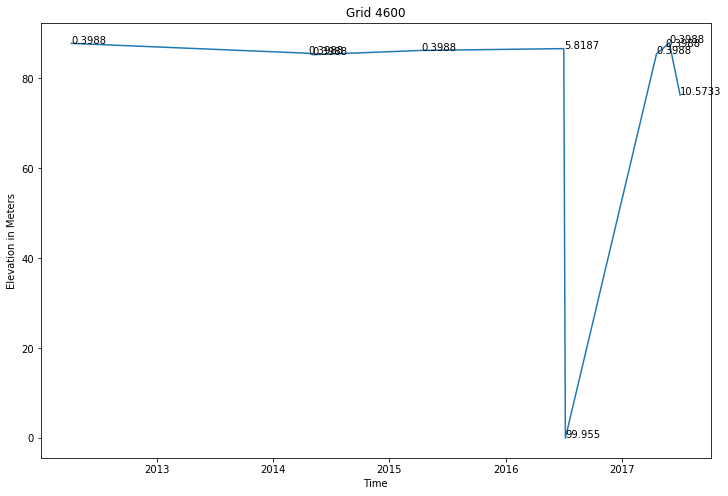

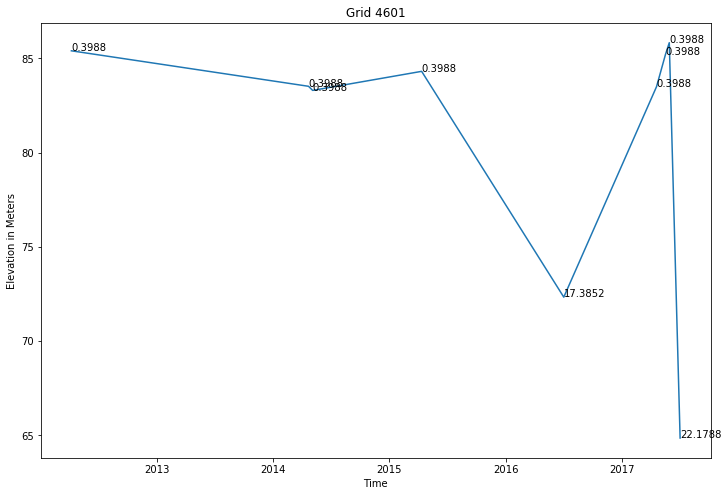

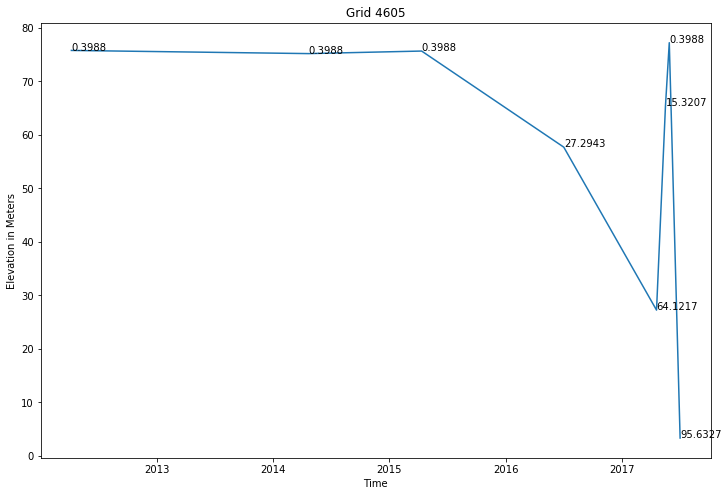

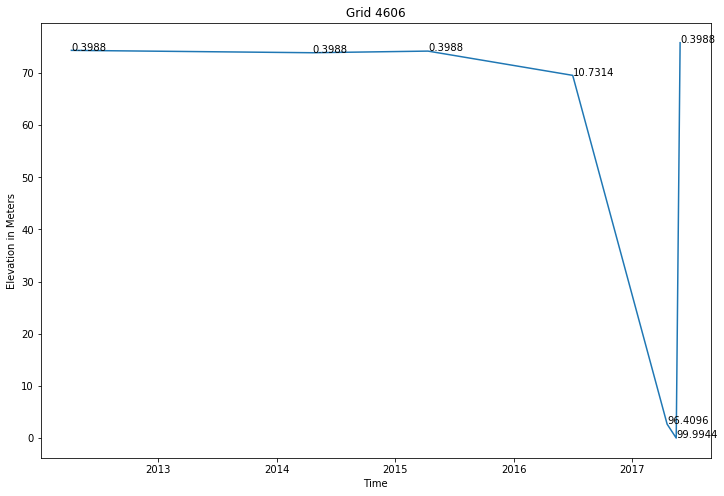

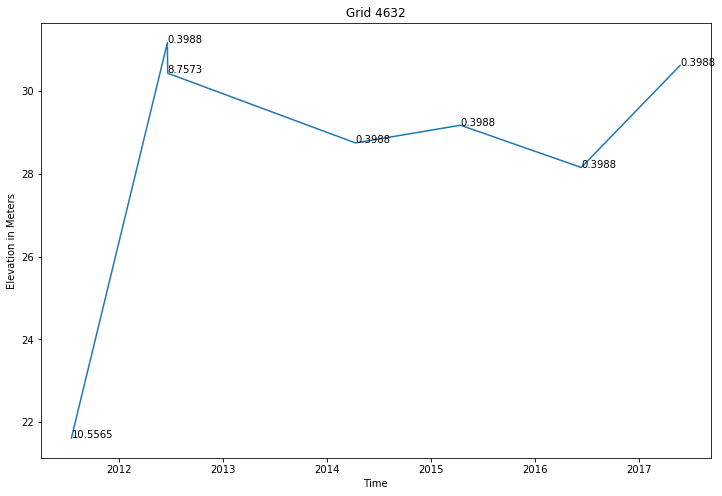

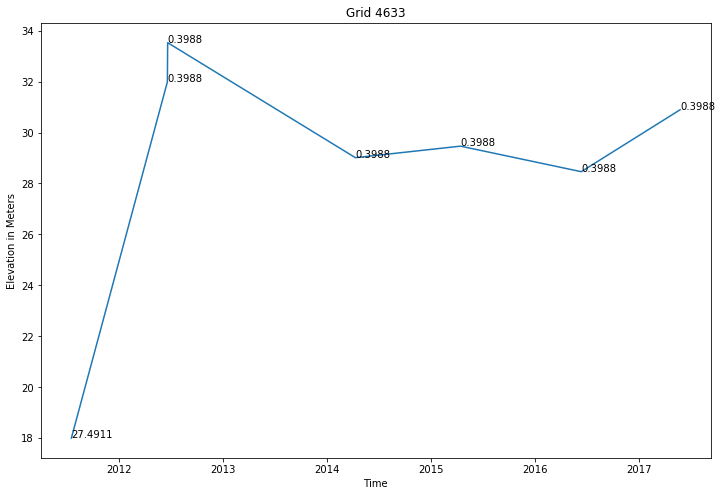

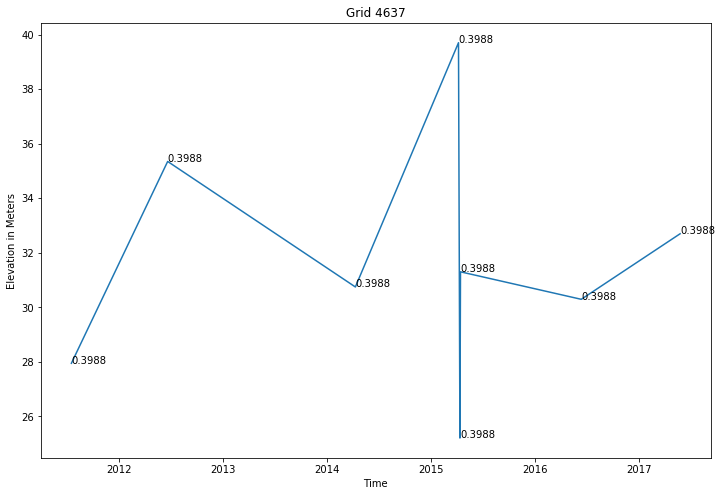

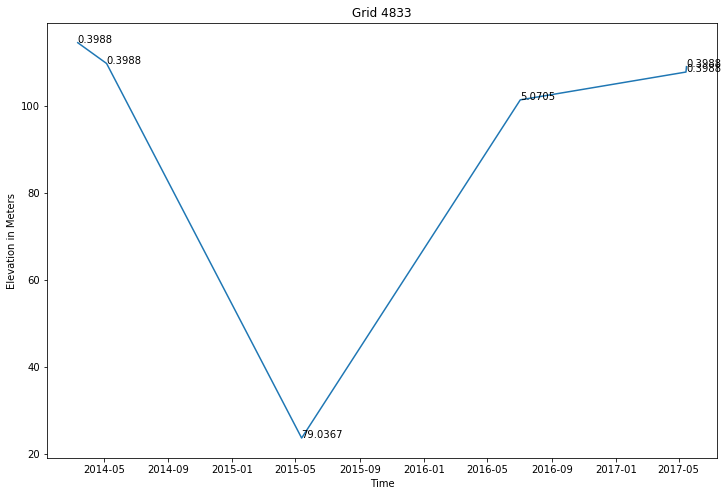

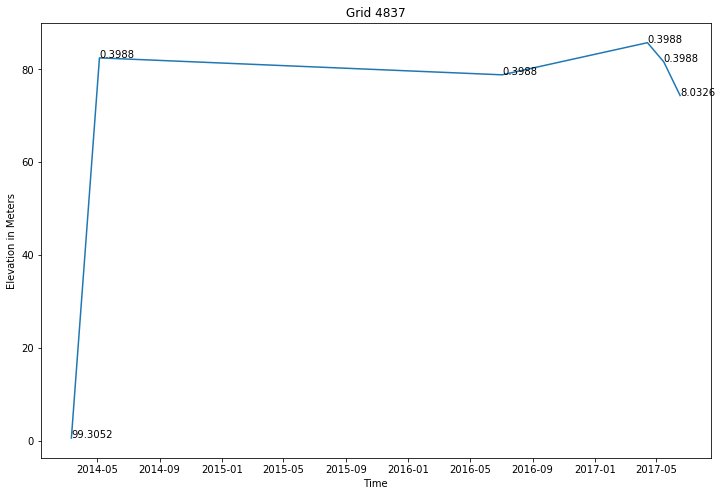

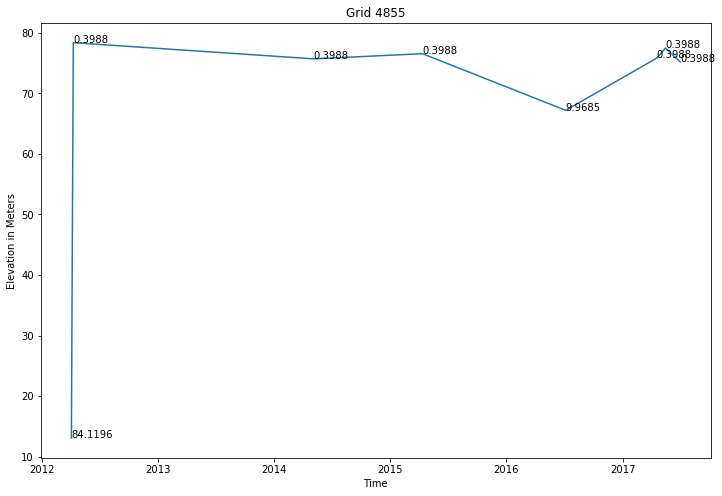

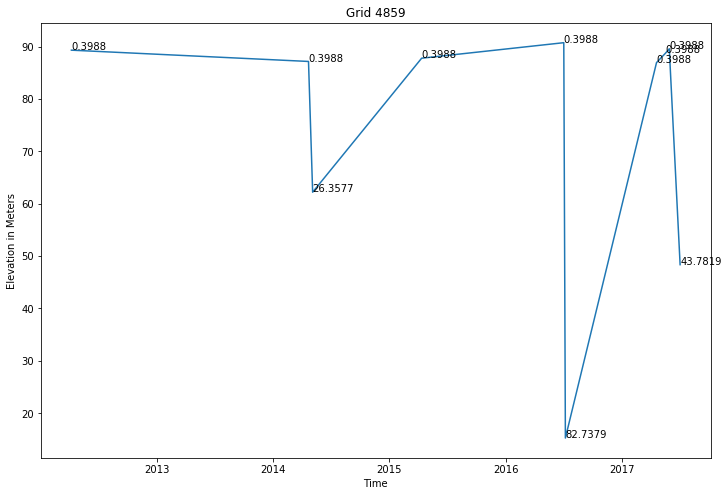

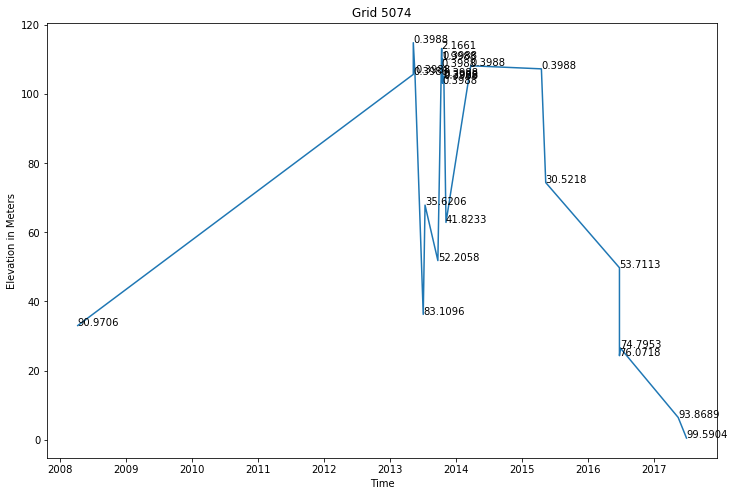

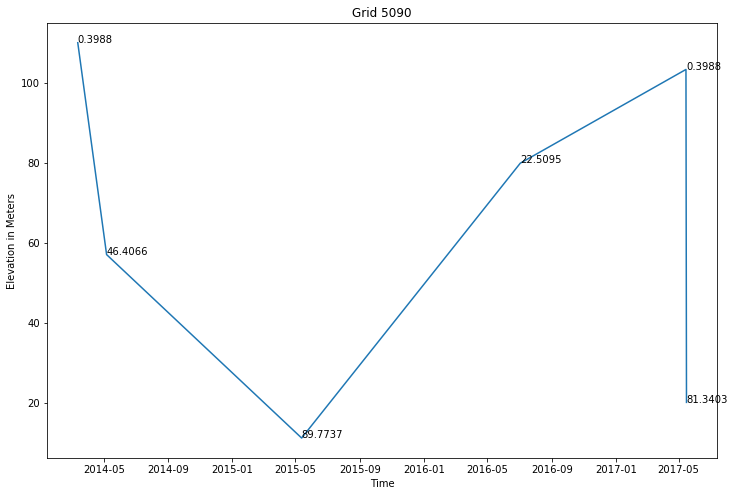

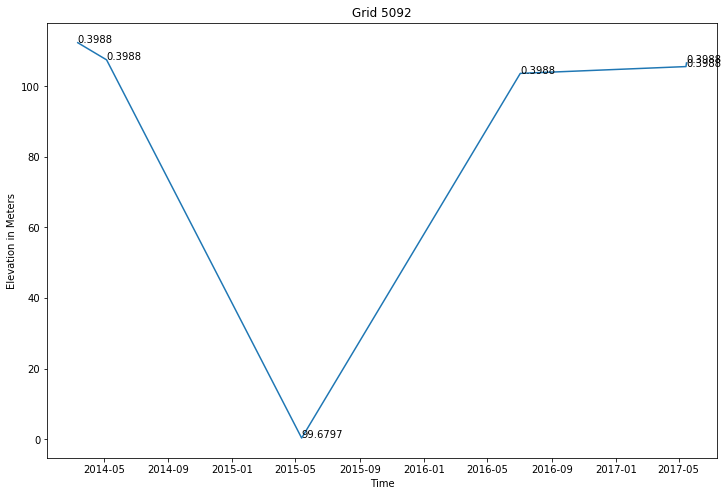

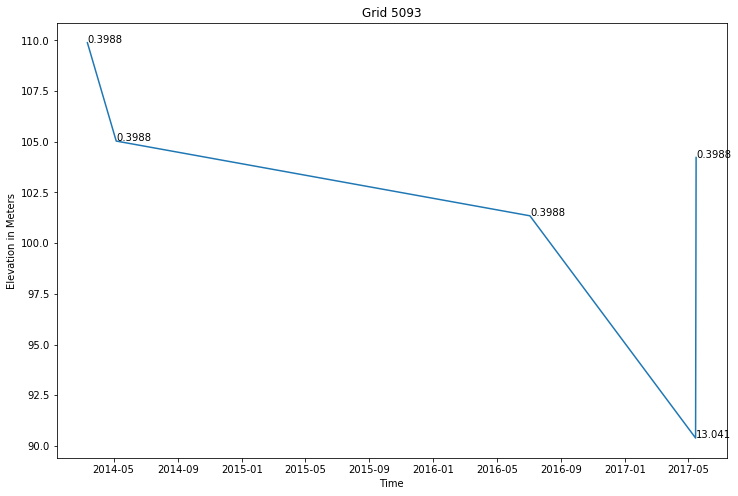

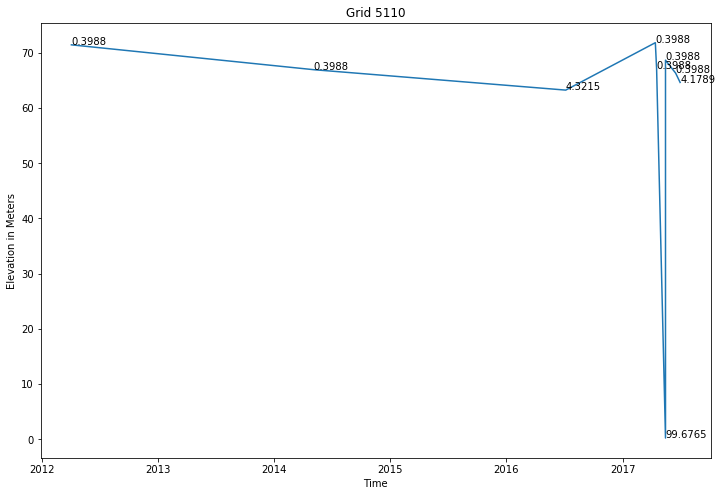

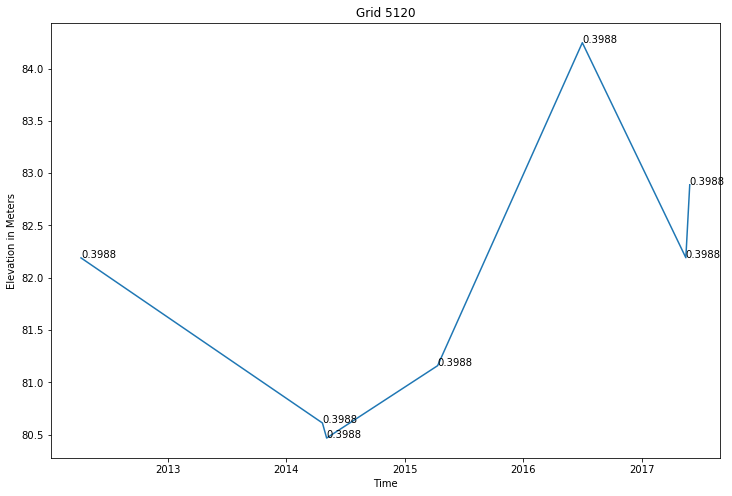

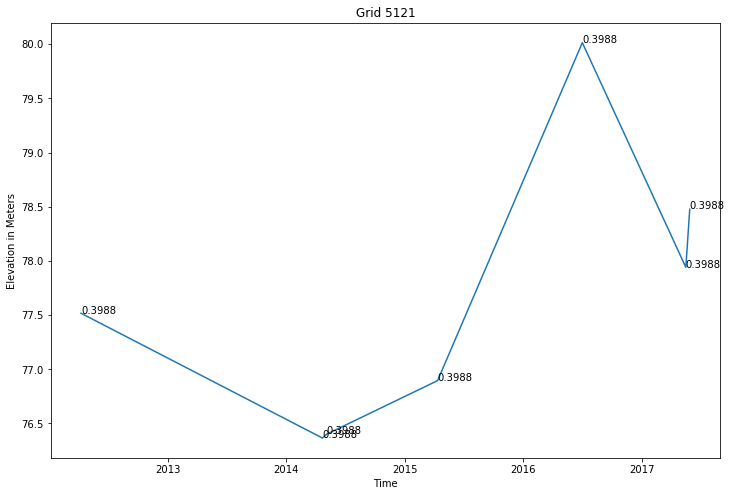

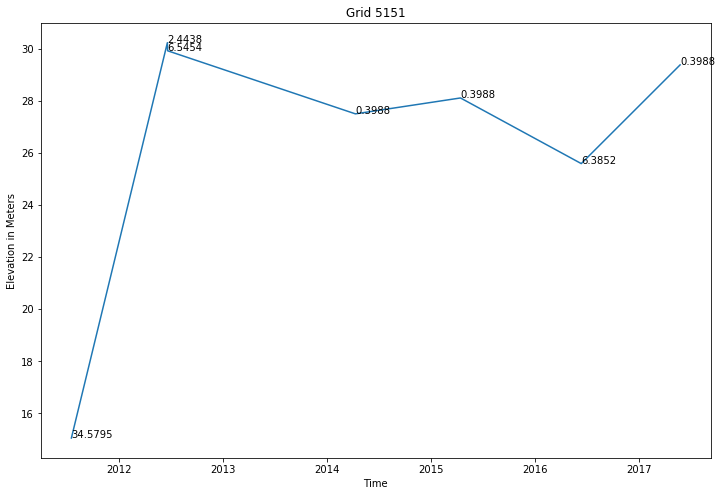

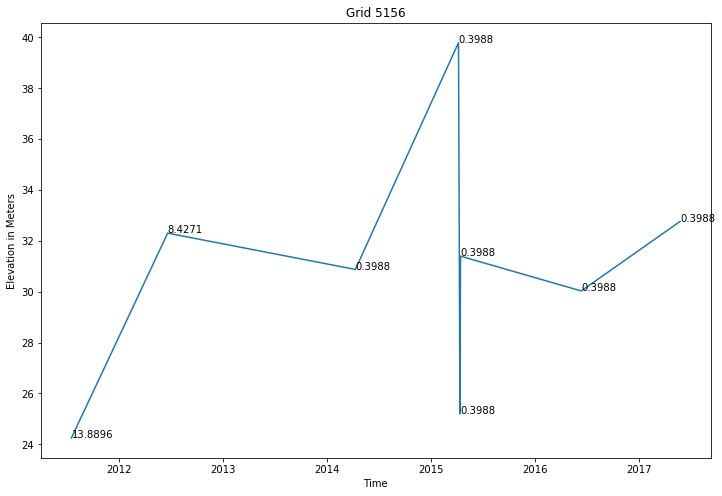

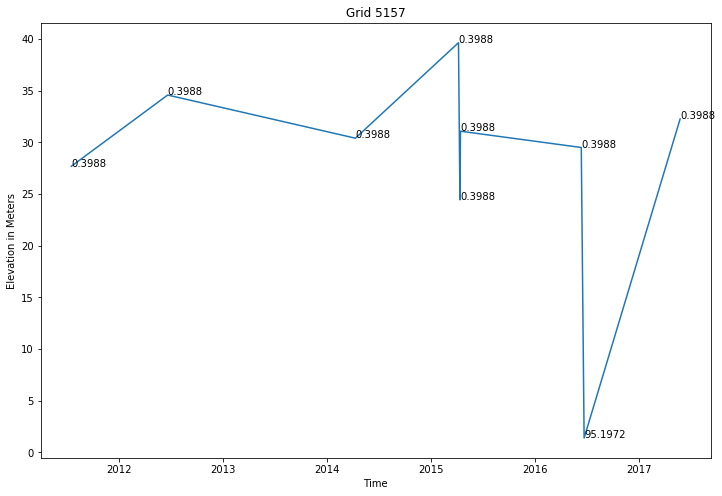

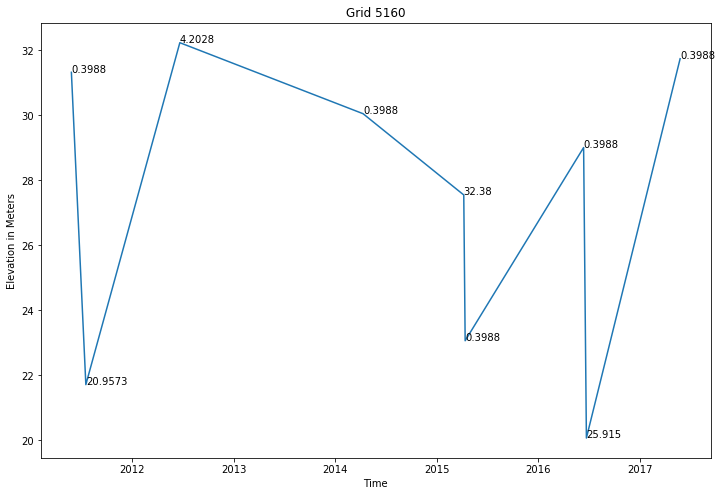

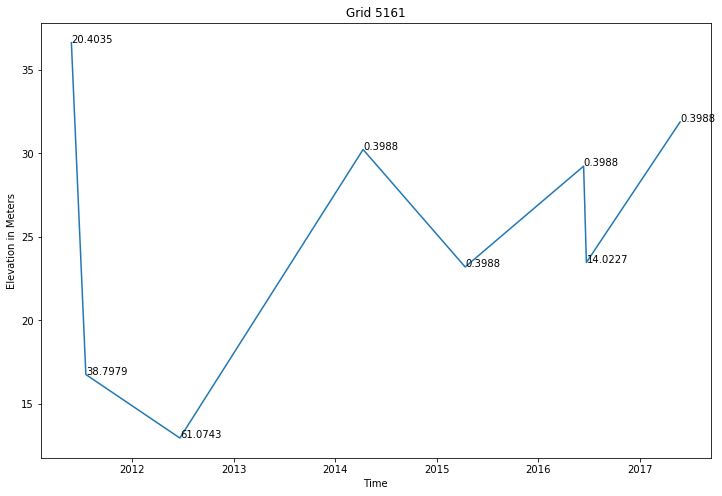

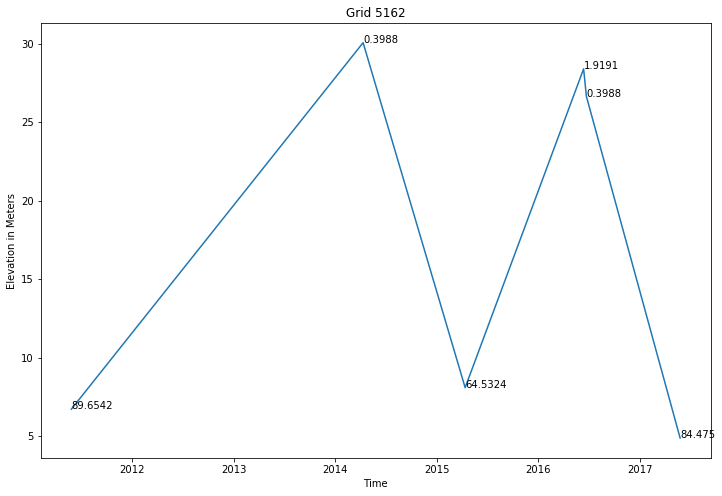

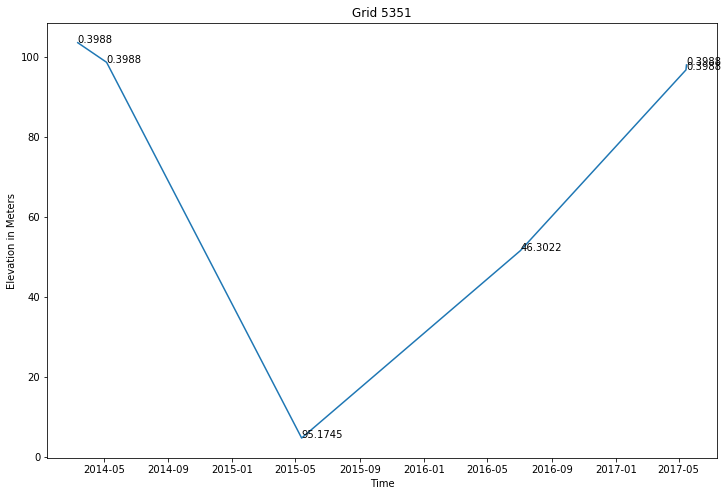

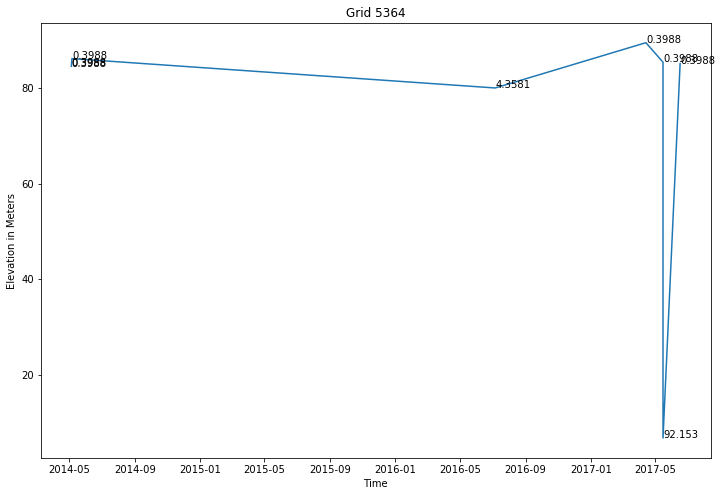

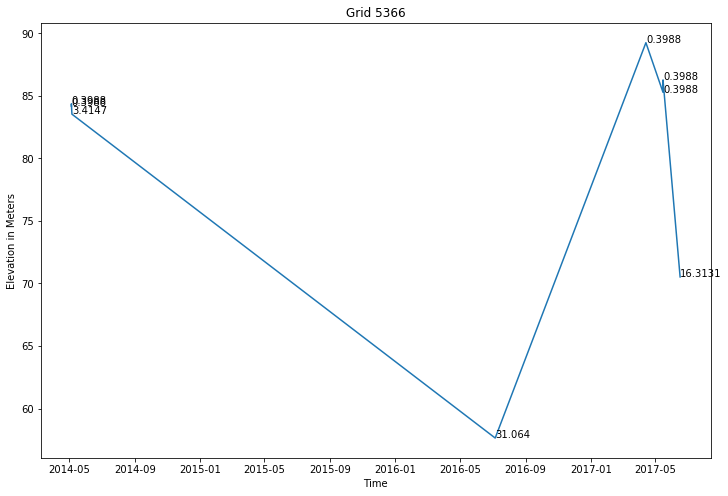

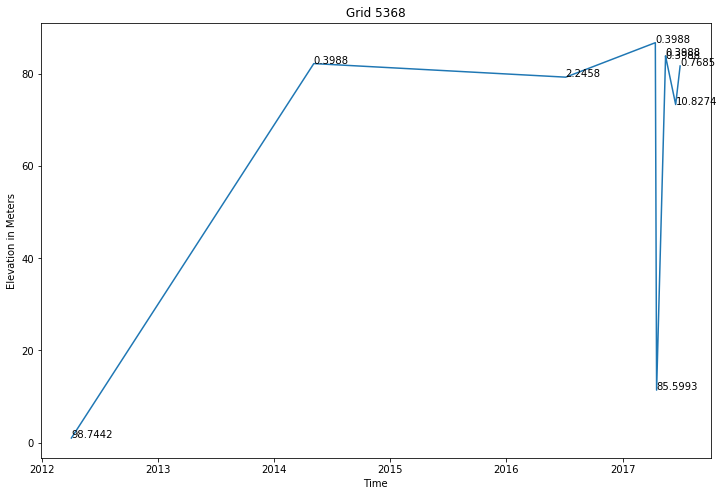

In [231]:
for _, grid in features.iloc[:80].iterrows():
    generate_plot(grid, labels=True, out_dir='./plots/' + str(grid.name) + '.svg', markersize=12)